In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
import squarify  # для treemap
from lifelines import KaplanMeierFitter  # для survival analysis
from scipy import stats
import networkx as nx  # для network analysis

# Настройки для отображения
warnings.filterwarnings('ignore')

# Безопасная настройка стиля matplotlib
try:
    plt.style.use('seaborn-v0_8')
except OSError:
    try:
        plt.style.use('seaborn')
    except OSError:
        plt.style.use('default')
        print("Используется стандартный стиль matplotlib")

sns.set_palette("husl")

# Настройки pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Библиотеки успешно импортированы")


Библиотеки успешно импортированы


In [2]:
# Загрузка данных
print("Загружаем данные о мошенничестве...")

# Загрузка основного датасета
df = pd.read_parquet('data/transaction_fraud_data.parquet')

# Загрузка данных по валютным курсам
currency_data = pd.read_parquet('data/historical_currency_exchange.parquet')

# Функция для конвертации валют в USD
def convert_to_usd(df, currency_rates):
    """Конвертация amount в USD с использованием курсов валют"""
    df_converted = df.copy()
    
    # Создаем словарь курсов валют (используем последние доступные курсы)
    latest_rates = currency_rates.iloc[-1]  # Последняя дата
    
    # Маппинг стран к валютам
    country_currency_map = {
        'Nigeria': 'NGN',
        'Brazil': 'BRL', 
        'Russia': 'RUB',
        'Mexico': 'MXN',
        'Singapore': 'SGD',
        'Canada': 'CAD',
        'Australia': 'AUD',
        'United Kingdom': 'GBP',
        'European Union': 'EUR',
        'Japan': 'JPY',
        'USA': 'USD'
    }
    
    # Создаем столбец amount_usd
    df_converted['amount_usd'] = df_converted['amount'].copy()
    
    for country, currency_code in country_currency_map.items():
        if country in df_converted['country'].values and currency_code in latest_rates.index:
            mask = df_converted['country'] == country
            if currency_code != 'USD':
                # Конвертируем в USD
                exchange_rate = latest_rates[currency_code]
                df_converted.loc[mask, 'amount_usd'] = df_converted.loc[mask, 'amount'] / exchange_rate
                print(f"Конвертирован {country}: {currency_code} -> USD (курс: {exchange_rate:.4f})")
            else:
                print(f"{country}: уже в USD")
    
    return df_converted

# Применяем конвертацию валют
df = convert_to_usd(df, currency_data)

print(f"Данные успешно загружены!")
print(f"Размер основного датасета: {df.shape[0]:,} строк, {df.shape[1]} столбцов")
print(f"Размер данных по курсам валют: {currency_data.shape[0]:,} строк, {currency_data.shape[1]} столбцов")

print("\nСтолбцы в основном датасете:")
print(df.columns.tolist())

print("\nПервые 3 строки:")
print(df.head(3))


Загружаем данные о мошенничестве...
Конвертирован Nigeria: NGN -> USD (курс: 1642.3472)
Конвертирован Brazil: BRL -> USD (курс: 5.7617)
Конвертирован Russia: RUB -> USD (курс: 97.5015)
Конвертирован Mexico: MXN -> USD (курс: 20.0488)
Конвертирован Singapore: SGD -> USD (курс: 1.3236)
Конвертирован Canada: CAD -> USD (курс: 1.3910)
Конвертирован Australia: AUD -> USD (курс: 1.5222)
Конвертирован Japan: JPY -> USD (курс: 153.1600)
USA: уже в USD
Данные успешно загружены!
Размер основного датасета: 7,483,766 строк, 24 столбцов
Размер данных по курсам валют: 31 строк, 12 столбцов

Столбцы в основном датасете:
['transaction_id', 'customer_id', 'card_number', 'timestamp', 'vendor_category', 'vendor_type', 'vendor', 'amount', 'currency', 'country', 'city', 'city_size', 'card_type', 'is_card_present', 'device', 'channel', 'device_fingerprint', 'ip_address', 'is_outside_home_country', 'is_high_risk_vendor', 'is_weekend', 'last_hour_activity', 'is_fraud', 'amount_usd']

Первые 3 строки:
  transa

In [3]:
# Первичный анализ данных
def analyze_dataset(df):
    """Функция для первичного анализа датасета"""
    print("=== БАЗОВАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ ===")
    print(f"Размер датасета: {df.shape[0]:,} строк, {df.shape[1]} столбцов")
    print(f"Объем данных в памяти: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n=== ТИПЫ ДАННЫХ ===")
    print(df.dtypes)
    
    print("\n=== ПРОПУЩЕННЫЕ ЗНАЧЕНИЯ ===")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_info = pd.DataFrame({
        'Пропущенные значения': missing_data,
        'Процент': missing_percent
    }).sort_values('Пропущенные значения', ascending=False)
    print(missing_info[missing_info['Пропущенные значения'] > 0])
    
    print("\n=== ПЕРВЫЕ 5 СТРОК ===")
    print(df.head())
    
    return missing_info

# Запуск анализа данных
missing_info = analyze_dataset(df)

print("Анализ данных завершен.")


=== БАЗОВАЯ ИНФОРМАЦИЯ О ДАТАСЕТЕ ===
Размер датасета: 7,483,766 строк, 24 столбцов
Объем данных в памяти: 7536.67 MB

=== ТИПЫ ДАННЫХ ===
transaction_id                     object
customer_id                        object
card_number                         int64
timestamp                  datetime64[us]
vendor_category                    object
vendor_type                        object
vendor                             object
amount                            float64
currency                           object
country                            object
city                               object
city_size                          object
card_type                          object
is_card_present                      bool
device                             object
channel                            object
device_fingerprint                 object
ip_address                         object
is_outside_home_country              bool
is_high_risk_vendor                  bool
is_weekend           

In [4]:
# Анализ информативности столбцов
def analyze_column_informativeness(df):
    """Анализ информативности столбцов для принятия решения об удалении"""
    
    # Проверяем какие столбцы есть в данных
    available_analysis_columns = ['device_fingerprint', 'ip_address', 'transaction_id', 
                                 'customer_id', 'card_number']
    columns_to_analyze = [col for col in available_analysis_columns if col in df.columns]
    
    results = {}
    
    print("=== АНАЛИЗ ИНФОРМАТИВНОСТИ СТОЛБЦОВ ===\n")
    
    for col in columns_to_analyze:
        if col in df.columns:
            unique_count = df[col].nunique()
            total_count = len(df)
            unique_ratio = unique_count / total_count
            
            print(f"СТОЛБЕЦ: {col}")
            print(f"  Уникальных значений: {unique_count:,} из {total_count:,}")
            print(f"  Доля уникальных: {unique_ratio:.4f} ({unique_ratio*100:.2f}%)")
            
            # Анализ информативности
            if unique_ratio > 0.95:
                recommendation = "УДАЛИТЬ - слишком высокая уникальность"
            elif unique_ratio < 0.01:
                recommendation = "УДАЛИТЬ - слишком низкая вариативность"
            else:
                recommendation = "ОСТАВИТЬ - потенциально информативен"
            
            print(f"  Рекомендация: {recommendation}")
            
            # Примеры значений
            print(f"  Примеры значений: {df[col].head(3).tolist()}")
            print()
            
            results[col] = {
                'unique_count': unique_count,
                'unique_ratio': unique_ratio,
                'recommendation': recommendation
            }
        else:
            print(f"Столбец {col} не найден в данных")
    
    return results

# Создание функции для удаления неинформативных столбцов
def remove_uninformative_columns(df, columns_analysis):
    """Удаление неинформативных столбцов на основе анализа"""
    columns_to_remove = []
    
    for col, analysis in columns_analysis.items():
        if "УДАЛИТЬ" in analysis['recommendation']:
            columns_to_remove.append(col)
    
    print(f"Столбцы для удаления: {columns_to_remove}")
    
    if columns_to_remove:
        df_cleaned = df.drop(columns=columns_to_remove)
        print(f"Размер данных до очистки: {df.shape}")
        print(f"Размер данных после очистки: {df_cleaned.shape}")
        return df_cleaned, columns_to_remove
    else:
        print("Столбцы для удаления не найдены")
        return df, []

# Запуск анализа информативности столбцов
columns_analysis = analyze_column_informativeness(df)
df_cleaned, removed_columns = remove_uninformative_columns(df, columns_analysis)

print("Анализ информативности завершен")


=== АНАЛИЗ ИНФОРМАТИВНОСТИ СТОЛБЦОВ ===

СТОЛБЕЦ: device_fingerprint
  Уникальных значений: 785,462 из 7,483,766
  Доля уникальных: 0.1050 (10.50%)
  Рекомендация: ОСТАВИТЬ - потенциально информативен
  Примеры значений: ['e8e6160445c935fd0001501e4cbac8bc', 'a73043a57091e775af37f252b3a32af9', '218864e94ceaa41577d216b149722261']

СТОЛБЕЦ: ip_address
  Уникальных значений: 7,477,187 из 7,483,766
  Доля уникальных: 0.9991 (99.91%)
  Рекомендация: УДАЛИТЬ - слишком высокая уникальность
  Примеры значений: ['197.153.60.199', '208.123.221.203', '10.194.159.204']

СТОЛБЕЦ: transaction_id
  Уникальных значений: 7,477,306 из 7,483,766
  Доля уникальных: 0.9991 (99.91%)
  Рекомендация: УДАЛИТЬ - слишком высокая уникальность
  Примеры значений: ['TX_a0ad2a2a', 'TX_3599c101', 'TX_a9461c6d']

СТОЛБЕЦ: customer_id
  Уникальных значений: 4,869 из 7,483,766
  Доля уникальных: 0.0007 (0.07%)
  Рекомендация: УДАЛИТЬ - слишком низкая вариативность
  Примеры значений: ['CUST_72886', 'CUST_70474', 'CUST_10

In [5]:
# Создание дополнительных признаков
def create_additional_features(df):
    """Создание дополнительных признаков для анализа"""
    df_enhanced = df.copy()
    
    print("=== СОЗДАНИЕ ДОПОЛНИТЕЛЬНЫХ ПРИЗНАКОВ ===")
    
    # Преобразование timestamp в datetime если нужно
    if 'timestamp' in df_enhanced.columns:
        if df_enhanced['timestamp'].dtype == 'object':
            df_enhanced['timestamp'] = pd.to_datetime(df_enhanced['timestamp'])
        
        # Извлечение временных признаков
        df_enhanced['hour'] = df_enhanced['timestamp'].dt.hour
        df_enhanced['day_of_week'] = df_enhanced['timestamp'].dt.dayofweek
        df_enhanced['day_name'] = df_enhanced['timestamp'].dt.day_name()
        
        print("✓ Созданы временные признаки: hour, day_of_week, day_name")
    
    # Категоризация размера транзакции
    # Проверяем наличие столбца amount_usd (после конвертации валют)
    amount_col = 'amount_usd' if 'amount_usd' in df_enhanced.columns else 'amount'
    
    if amount_col in df_enhanced.columns:
        # Определение квартилей для категоризации
        q25 = df_enhanced[amount_col].quantile(0.25)
        q50 = df_enhanced[amount_col].quantile(0.50)
        q75 = df_enhanced[amount_col].quantile(0.75)
        q95 = df_enhanced[amount_col].quantile(0.95)
        
        def categorize_transaction_size(amount):
            if amount <= q25:
                return 'Малая'
            elif amount <= q50:
                return 'Средняя'
            elif amount <= q75:
                return 'Большая'
            elif amount <= q95:
                return 'Очень большая'
            else:
                return 'Экстремальная'
        
        df_enhanced['transaction_size_category'] = df_enhanced[amount_col].apply(categorize_transaction_size)
        
        print(f"✓ Создан признак transaction_size_category")
        print(f"  Границы: Малая ≤{q25:.2f}, Средняя ≤{q50:.2f}, Большая ≤{q75:.2f}, Очень большая ≤{q95:.2f}")
    
    # Обработка last_hour_activity (в данных это один столбец, возможно JSON/dict)
    if 'last_hour_activity' in df_enhanced.columns:
        print("✓ Найден столбец last_hour_activity")
        # Если это строка JSON, можно попробовать распарсить
        try:
            # Попробуем извлечь информацию из last_hour_activity
            sample_value = df_enhanced['last_hour_activity'].iloc[0]
            print(f"Пример значения last_hour_activity: {sample_value}")
            
            # Простые метрики на основе last_hour_activity
            df_enhanced['has_hour_activity'] = df_enhanced['last_hour_activity'].notna().astype(int)
            print("✓ Создан признак has_hour_activity")
            
        except Exception as e:
            print(f"Не удалось обработать last_hour_activity: {e}")
    
    # Соотношение с текущей транзакцией (используем правильное название столбца)
    if amount_col in df_enhanced.columns:
        # Создаем логарифм суммы в USD для корректного анализа
        df_enhanced['amount_log'] = np.log1p(df_enhanced[amount_col])
        print(f"✓ Создан признак amount_log на основе {amount_col}")
        
        # Добавляем информацию о валютах после конвертации
        if amount_col == 'amount_usd':
            print("✓ amount_log создан на основе USD - все суммы сконвертированы для корректного сравнения")
        else:
            print("⚠️ ВНИМАНИЕ: amount_log создан на основе исходных валют, не USD!")
    
    # Признак времени суток
    if 'hour' in df_enhanced.columns:
        def get_time_period(hour):
            if 6 <= hour < 12:
                return 'Утро'
            elif 12 <= hour < 18:
                return 'День'
            elif 18 <= hour < 22:
                return 'Вечер'
            else:
                return 'Ночь'
        
        df_enhanced['time_period'] = df_enhanced['hour'].apply(get_time_period)
        print("✓ Создан признак time_period")
    
    print(f"\nРазмер данных: {df_enhanced.shape}")
    print(f"Добавлено признаков: {df_enhanced.shape[1] - df.shape[1]}")
    
    return df_enhanced

# Запуск создания дополнительных признаков
df_with_features = create_additional_features(df_cleaned)

print("Создание признаков завершено")


=== СОЗДАНИЕ ДОПОЛНИТЕЛЬНЫХ ПРИЗНАКОВ ===
✓ Созданы временные признаки: hour, day_of_week, day_name
✓ Создан признак transaction_size_category
  Границы: Малая ≤160.80, Средняя ≤341.01, Большая ≤588.85, Очень большая ≤1664.29
✓ Найден столбец last_hour_activity
Пример значения last_hour_activity: {'num_transactions': 1197, 'total_amount': 33498556.080464985, 'unique_merchants': 105, 'unique_countries': 12, 'max_single_amount': 1925480.6324148502}
✓ Создан признак has_hour_activity
✓ Создан признак amount_log на основе amount_usd
✓ amount_log создан на основе USD - все суммы сконвертированы для корректного сравнения
✓ Создан признак time_period

Размер данных: (7483766, 27)
Добавлено признаков: 7
Создание признаков завершено


=== АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
РАСПРЕДЕЛЕНИЕ ТРАНЗАКЦИЙ:
               Количество  Процент
Легитимные        5989047  80.0272
Мошеннические     1494719  19.9728


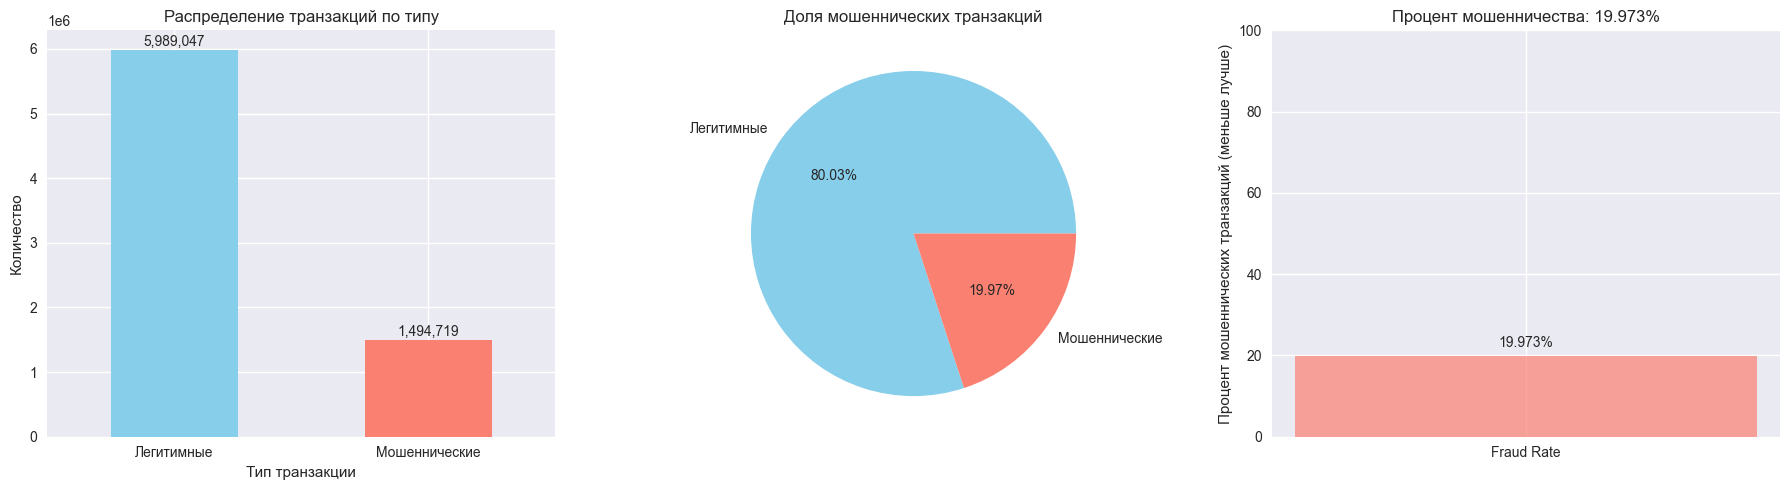


АНАЛИЗ БАЛАНСА КЛАССОВ:
Соотношение легитимных к мошенническим: 4.0:1
ОТНОСИТЕЛЬНО СБАЛАНСИРОВАННЫЕ КЛАССЫ (fraud rate = 19.973%)

=== ТРЕНДЫ МОШЕННИЧЕСТВА ПО ВРЕМЕНИ ===


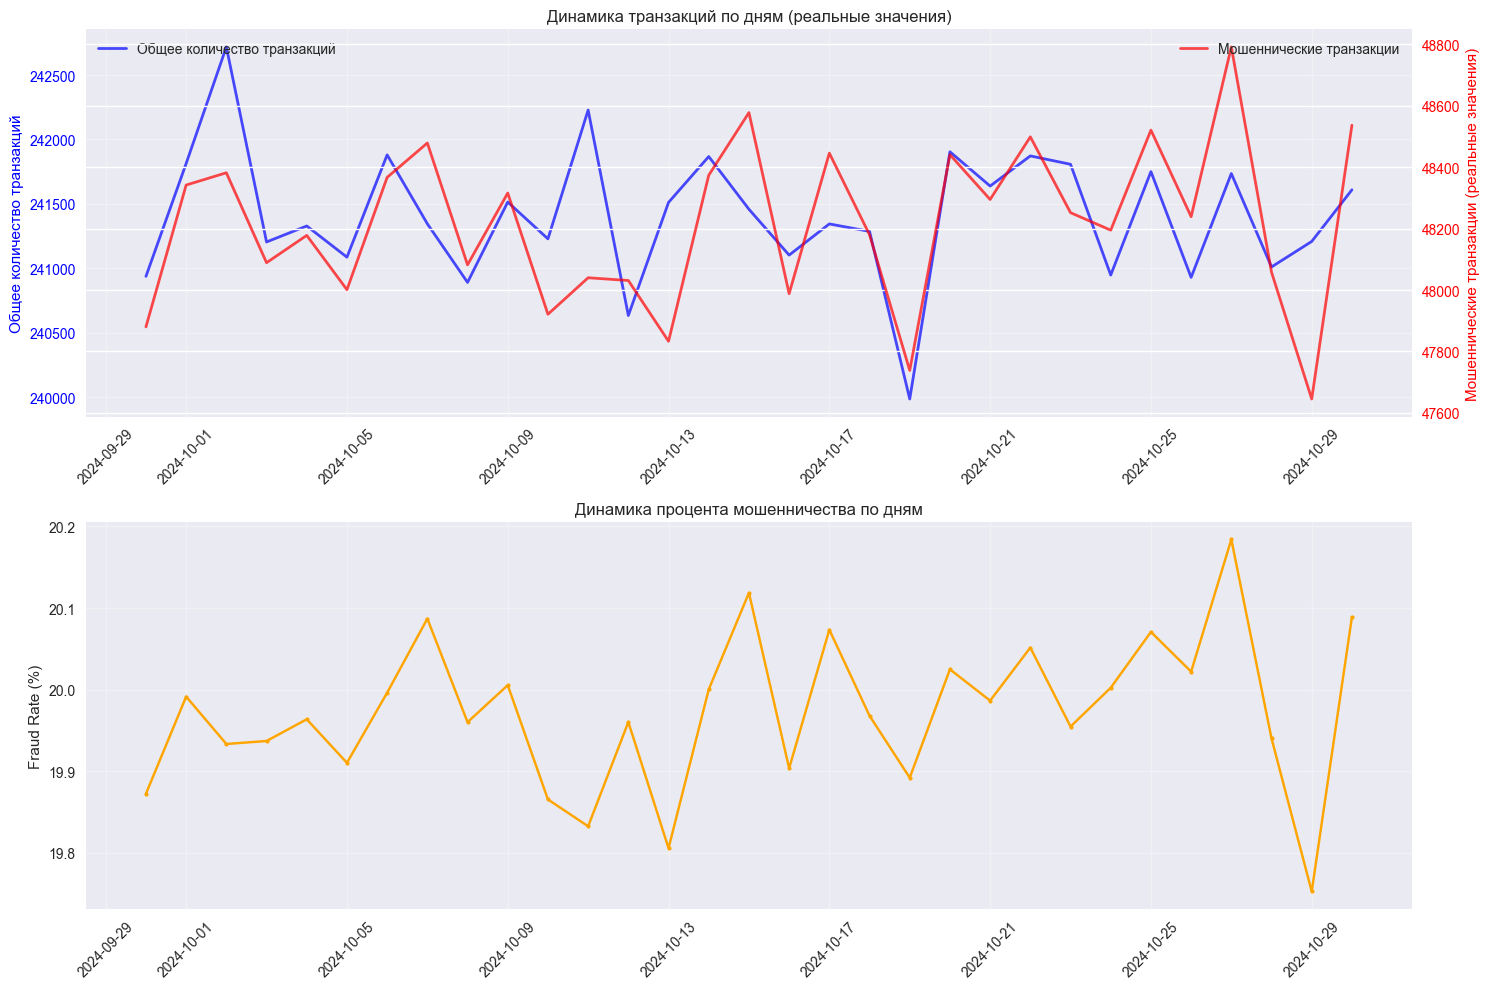

Средний fraud rate: 19.973%
Минимальный fraud rate: 19.753%
Максимальный fraud rate: 20.184%
Стандартное отклонение fraud rate: 0.094%
Анализ целевой переменной завершен


In [6]:
# Анализ распределения целевой переменной
def analyze_target_variable(df):
    """Анализ распределения целевой переменной is_fraud"""
    
    if 'is_fraud' not in df.columns:
        print("Столбец 'is_fraud' не найден в данных")
        return
    
    print("=== АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")
    
    # Основная статистика
    fraud_counts = df['is_fraud'].value_counts()
    fraud_percentages = df['is_fraud'].value_counts(normalize=True) * 100
    
    # Таблица с результатами
    fraud_summary = pd.DataFrame({
        'Количество': fraud_counts,
        'Процент': fraud_percentages
    })
    fraud_summary.index = ['Легитимные', 'Мошеннические']
    
    print("РАСПРЕДЕЛЕНИЕ ТРАНЗАКЦИЙ:")
    print(fraud_summary)
    
    # Создание графиков
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # График 1: Столбчатая диаграмма количества
    fraud_counts.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
    axes[0].set_title('Распределение транзакций по типу')
    axes[0].set_xlabel('Тип транзакции')
    axes[0].set_ylabel('Количество')
    axes[0].set_xticklabels(['Легитимные', 'Мошеннические'], rotation=0)
    
    # Добавление значений на столбцы
    for i, v in enumerate(fraud_counts.values):
        axes[0].text(i, v + max(fraud_counts) * 0.01, f'{v:,}', ha='center')
    
    # График 2: Круговая диаграмма
    axes[1].pie(fraud_counts.values, labels=['Легитимные', 'Мошеннические'], 
                autopct='%1.2f%%', colors=['skyblue', 'salmon'])
    axes[1].set_title('Доля мошеннических транзакций')
    
    # График 3: Доля мошенничества
    fraud_rate = fraud_percentages[1]
    axes[2].bar(['Fraud Rate'], [fraud_rate], color='salmon', alpha=0.7)
    axes[2].set_ylim(0, 100)
    axes[2].set_title(f'Процент мошенничества: {fraud_rate:.3f}%')
    axes[2].set_ylabel('Процент мошеннических транзакций (меньше лучше)')
    
    # Добавление значения на столбец
    axes[2].text(0, fraud_rate + 2, f'{fraud_rate:.3f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ дисбаланса классов
    print(f"\nАНАЛИЗ БАЛАНСА КЛАССОВ:")
    print(f"Соотношение легитимных к мошенническим: {fraud_counts[0] / fraud_counts[1]:.1f}:1")
    
    if fraud_rate < 5:
        print(f"СИЛЬНЫЙ ДИСБАЛАНС КЛАССОВ (fraud rate = {fraud_rate:.3f}%)")
        print("Рекомендуется использовать техники работы с несбалансированными данными")
    elif fraud_rate < 10:
        print(f"УМЕРЕННЫЙ ДИСБАЛАНС КЛАССОВ (fraud rate = {fraud_rate:.3f}%)")
    else:
        print(f"ОТНОСИТЕЛЬНО СБАЛАНСИРОВАННЫЕ КЛАССЫ (fraud rate = {fraud_rate:.3f}%)")
    
    return fraud_summary

# Анализ fraud rate по времени
def analyze_fraud_trends_over_time(df):
    """Анализ трендов мошенничества по времени"""
    
    if 'timestamp' not in df.columns or 'is_fraud' not in df.columns:
        print("Необходимые столбцы 'timestamp' и 'is_fraud' не найдены")
        return
    
    print("\n=== ТРЕНДЫ МОШЕННИЧЕСТВА ПО ВРЕМЕНИ ===")
    
    # Подготовка данных
    df_time = df.copy()
    df_time['date'] = df_time['timestamp'].dt.date
    
    # Группировка по датам
    daily_stats = df_time.groupby('date').agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).reset_index()
    
    daily_stats.columns = ['date', 'total_transactions', 'fraud_count', 'fraud_rate']
    daily_stats['fraud_rate'] = daily_stats['fraud_rate'] * 100
    
    # График тренда
    fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
    # График 1: Количество транзакций и мошенничества по дням (реальные значения)
    axes[0].plot(daily_stats['date'], daily_stats['total_transactions'], 
                label='Общее количество транзакций', color='blue', alpha=0.7, linewidth=2)
    
    # Создаем вторую ось Y для мошеннических транзакций (реальные значения)
    ax0_twin = axes[0].twinx()
    ax0_twin.plot(daily_stats['date'], daily_stats['fraud_count'], 
                  label='Мошеннические транзакции', color='red', alpha=0.7, linewidth=2)
    
    axes[0].set_ylabel('Общее количество транзакций', color='blue')
    ax0_twin.set_ylabel('Мошеннические транзакции (реальные значения)', color='red')
    axes[0].tick_params(axis='y', labelcolor='blue')
    ax0_twin.tick_params(axis='y', labelcolor='red')
    
    axes[0].set_title('Динамика транзакций по дням (реальные значения)')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)
    
    # Добавляем легенды
    axes[0].legend(loc='upper left')
    ax0_twin.legend(loc='upper right')
    
    # График 2: Fraud rate по дням
    axes[1].plot(daily_stats['date'], daily_stats['fraud_rate'], 
                color='orange', marker='o', markersize=3)
    axes[1].set_title('Динамика процента мошенничества по дням')
    axes[1].set_ylabel('Fraud Rate (%)')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Статистика по трендам
    print(f"Средний fraud rate: {daily_stats['fraud_rate'].mean():.3f}%")
    print(f"Минимальный fraud rate: {daily_stats['fraud_rate'].min():.3f}%")
    print(f"Максимальный fraud rate: {daily_stats['fraud_rate'].max():.3f}%")
    print(f"Стандартное отклонение fraud rate: {daily_stats['fraud_rate'].std():.3f}%")
    
    return daily_stats

# Запуск анализа целевой переменной
fraud_summary = analyze_target_variable(df_with_features)
daily_trends = analyze_fraud_trends_over_time(df_with_features)

print("Анализ целевой переменной завершен")


=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ СУММ ТРАНЗАКЦИЙ (amount_usd) ===
ОПИСАТЕЛЬНАЯ СТАТИСТИКА amount_usd:
count   7483766.0000
mean        519.5238
std         703.8698
min           0.0024
25%         160.8000
50%         341.0129
75%         588.8522
max       15521.6790
Name: amount_usd, dtype: float64


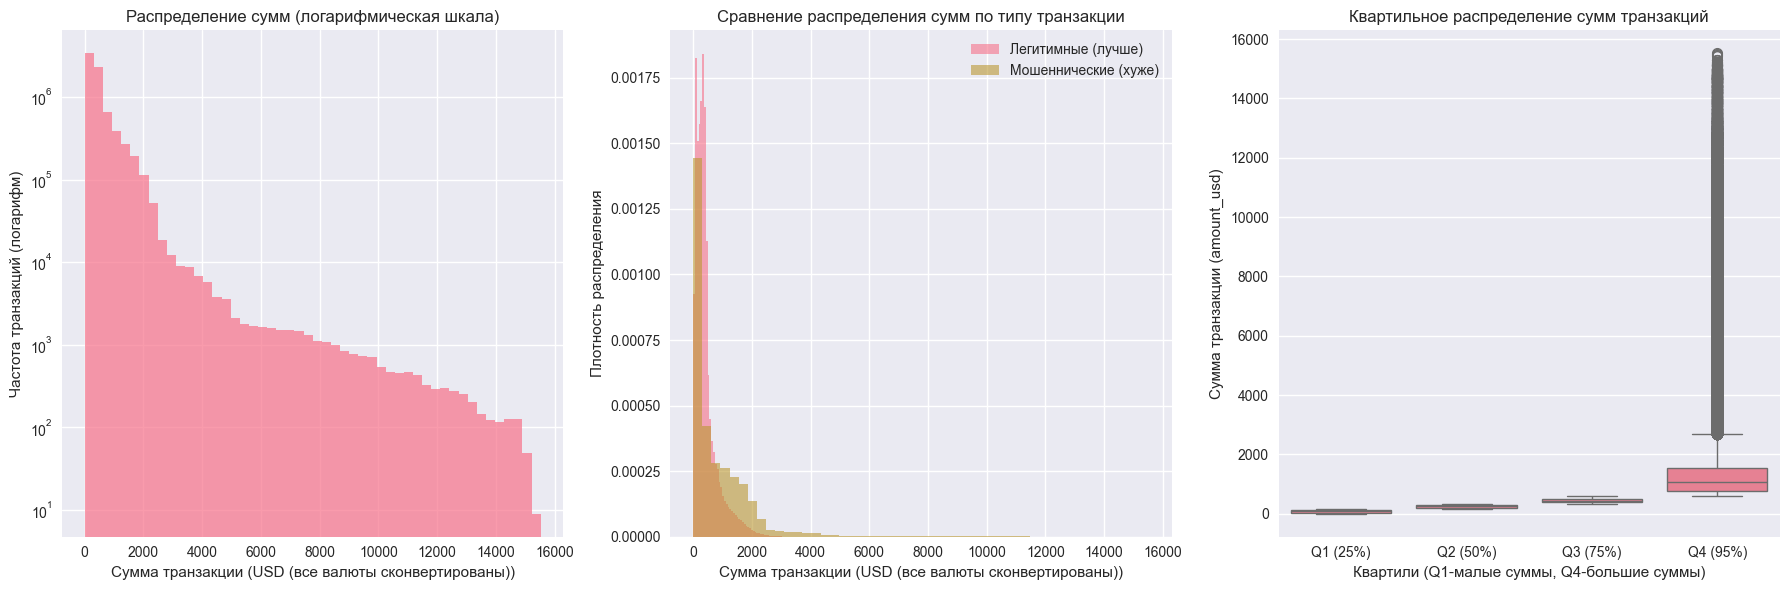


АНАЛИЗ ВЫБРОСОВ:
Выбросов: 734,508 (9.81%)
Верхняя граница: 1,230.93
Максимальная сумма: 15,521.68
=== АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ ===

COUNTRY:
  Уникальных значений: 12
  Топ-5 значений:
  {'Nigeria': 849840, 'Brazil': 804800, 'Russia': 793730, 'Mexico': 785704, 'Singapore': 588668}

VENDOR_CATEGORY:
  Уникальных значений: 8
  Топ-5 значений:
  {'Healthcare': 936770, 'Restaurant': 936178, 'Entertainment': 936173, 'Retail': 935883, 'Travel': 935790}

DEVICE:
  Уникальных значений: 9
  Топ-5 значений:
  {'Edge': 1189560, 'iOS App': 1143461, 'Chrome': 1132384, 'Android App': 1126117, 'Firefox': 1120952}

CHANNEL:
  Уникальных значений: 3
  Топ-5 значений:
  {'web': 4563141, 'mobile': 2269578, 'pos': 651047}


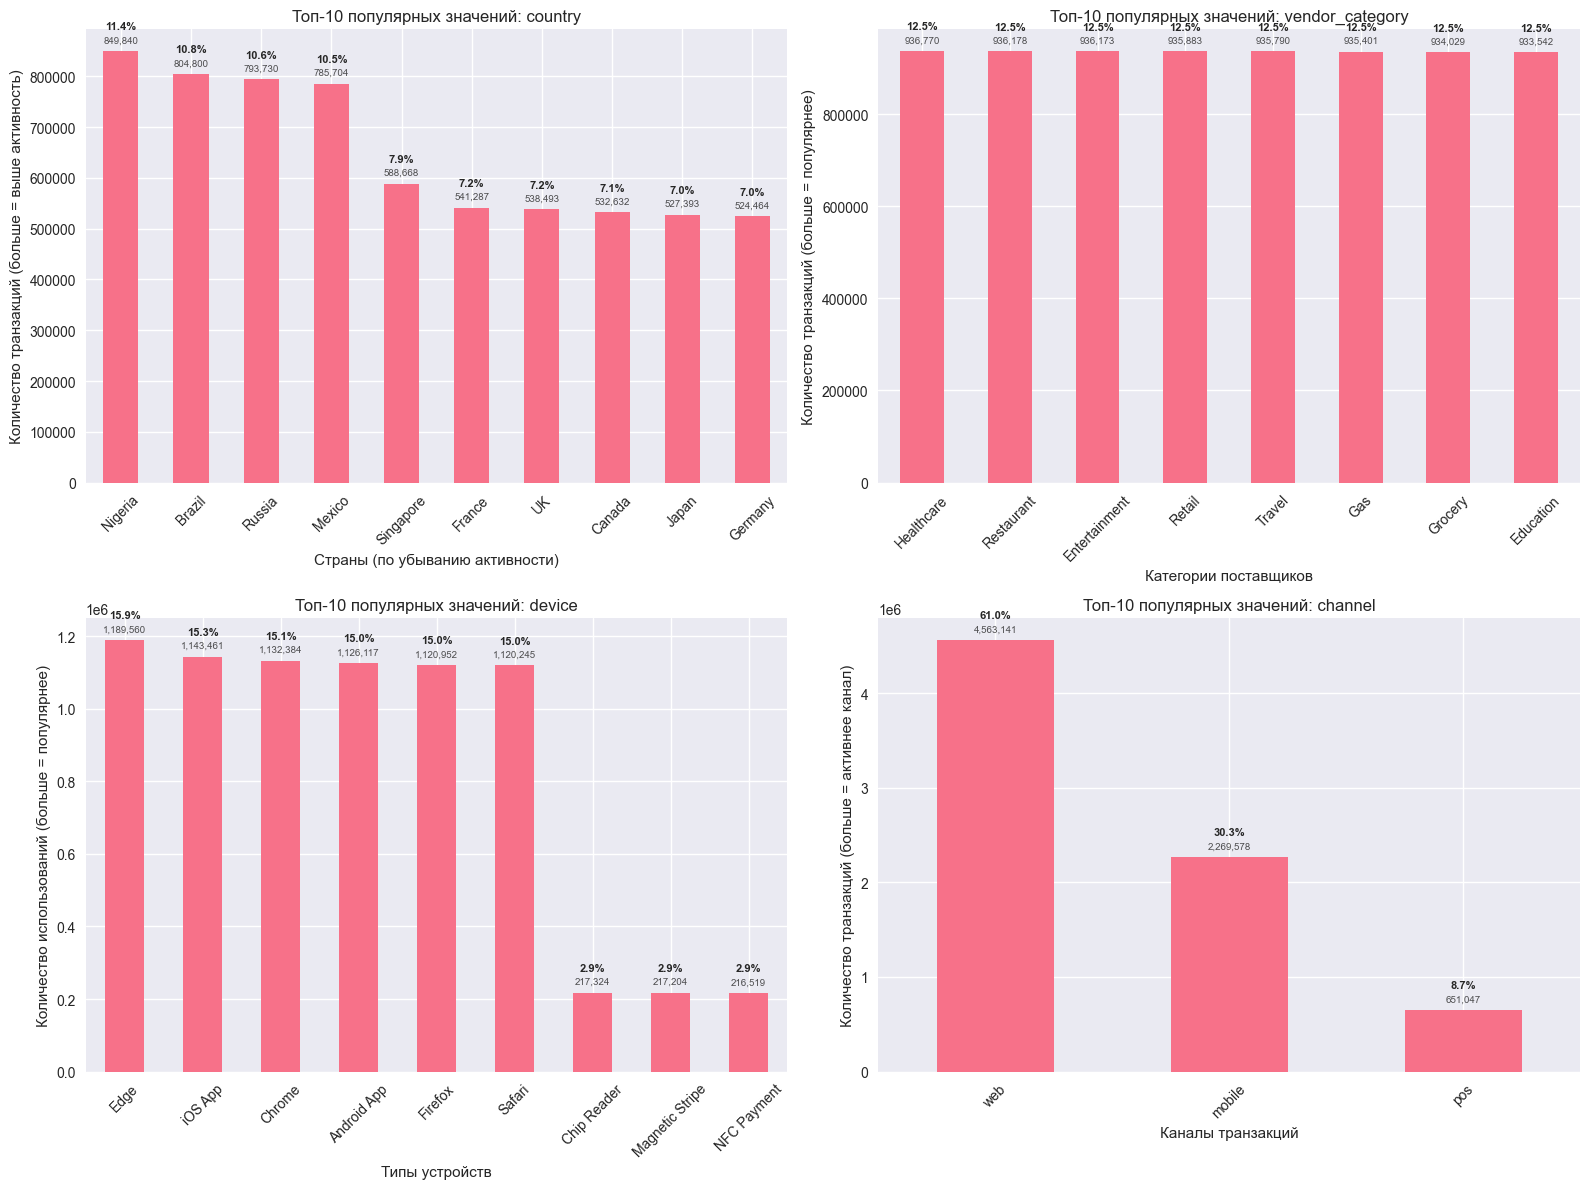

=== АНАЛИЗ ЧИСЛЕННЫХ ПРИЗНАКОВ ===
Анализируемые столбцы: ['amount', 'amount_usd', 'hour', 'day_of_week', 'has_hour_activity', 'amount_log']

amount_usd:
  Среднее: 519.5238
  Медиана: 341.0129
  Стд. отклонение: 703.8698
  Мин: 0.0024, Макс: 15521.6790

hour:
  Среднее: 12.1547
  Медиана: 12.0000
  Стд. отклонение: 6.5368
  Мин: 0.0000, Макс: 23.0000

day_of_week:
  Среднее: 2.8062
  Медиана: 3.0000
  Стд. отклонение: 2.0068
  Мин: 0.0000, Макс: 6.0000

amount_log:
  Среднее: 5.5577
  Медиана: 5.8348
  Стд. отклонение: 1.5040
  Мин: 0.0024, Макс: 9.6501


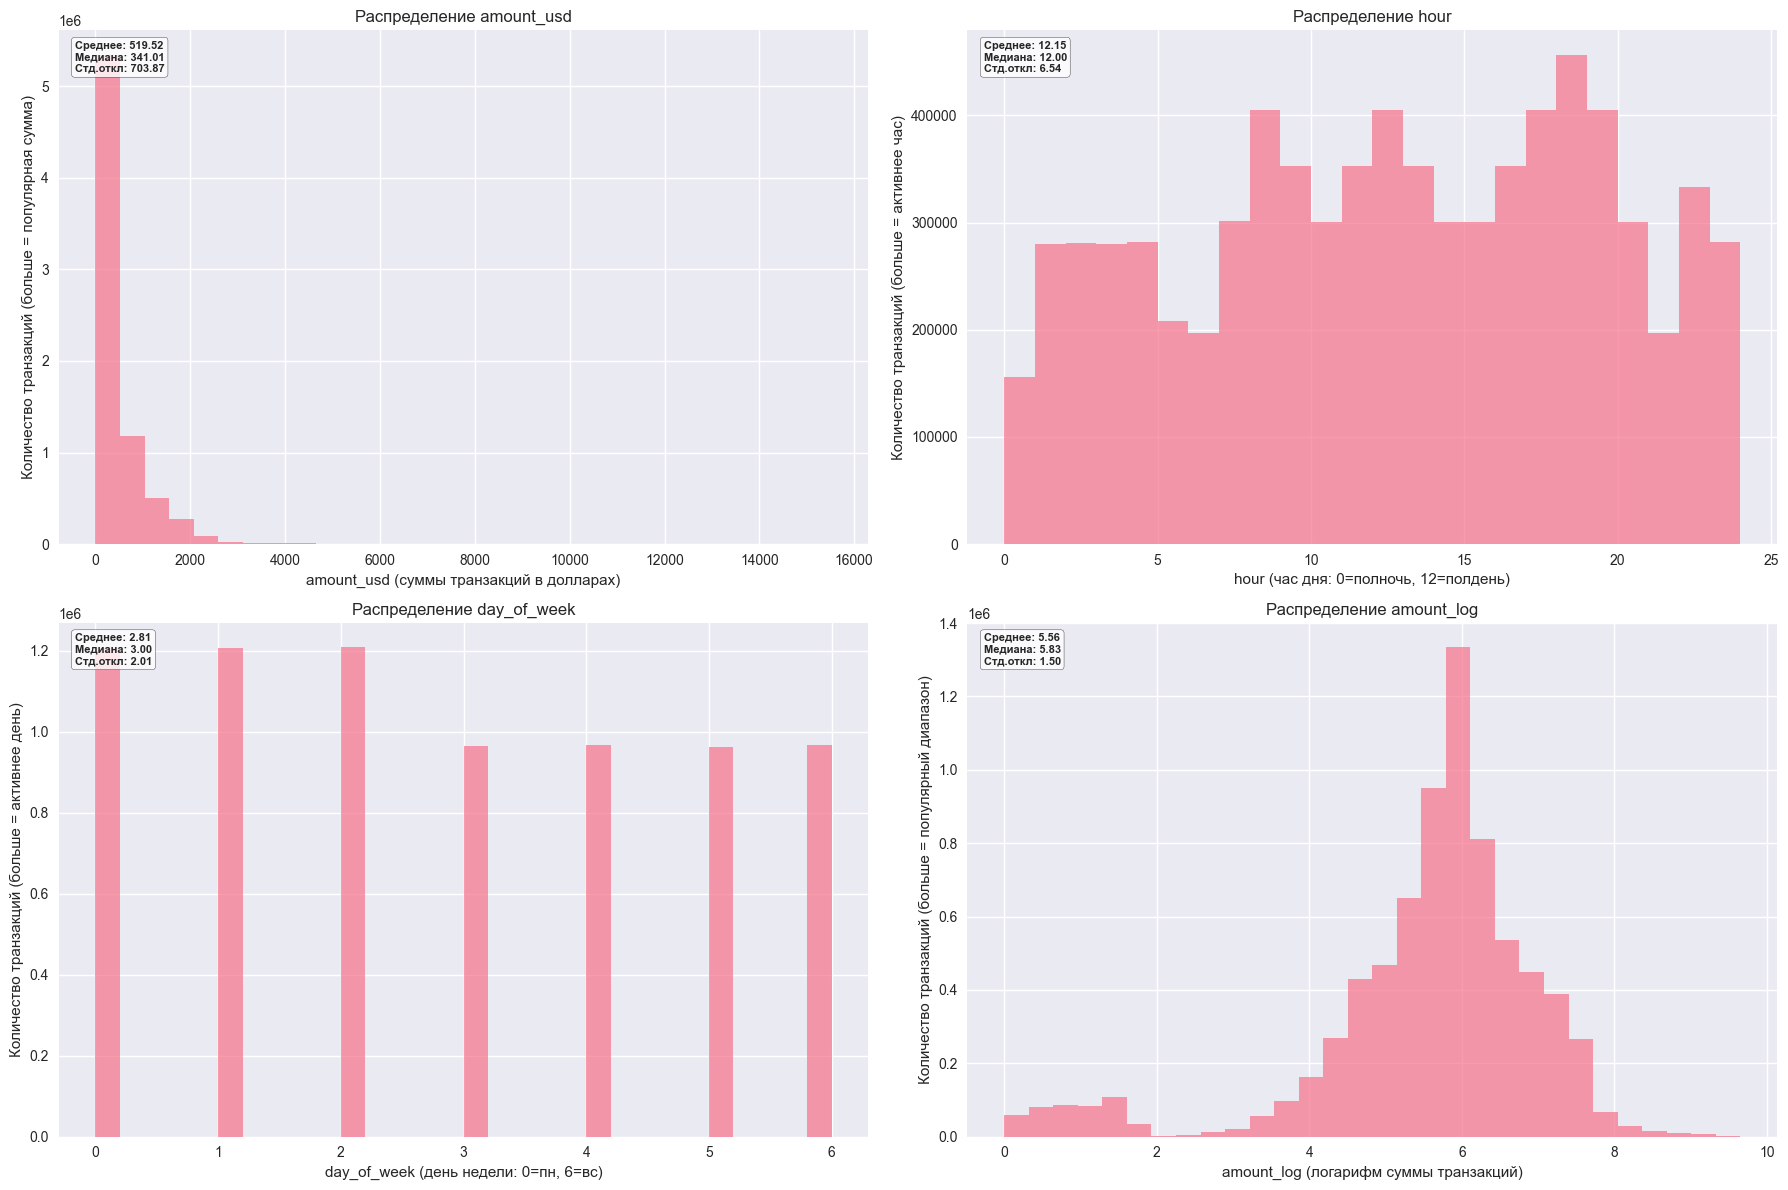

Анализ распределений завершен


In [7]:
# Анализ распределения ключевых переменных
def analyze_amount_distribution(df):
    """Анализ распределения сумм транзакций"""
    
    # Определяем правильное название столбца (приоритет USD после конвертации)
    amount_col = 'amount_usd' if 'amount_usd' in df.columns else 'amount'
    
    if amount_col not in df.columns:
        print(f"Столбец '{amount_col}' не найден")
        print(f"Доступные столбцы: {list(df.columns)}")
        return
    
    print(f"=== АНАЛИЗ РАСПРЕДЕЛЕНИЯ СУММ ТРАНЗАКЦИЙ ({amount_col}) ===")
    
    # Основная статистика
    print(f"ОПИСАТЕЛЬНАЯ СТАТИСТИКА {amount_col}:")
    print(df[amount_col].describe())
    
    # Создание графиков (убираем один график)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # График 1: Распределение с логарифмической шкалой
    df[amount_col].hist(bins=50, alpha=0.7, ax=axes[0])
    axes[0].set_yscale('log')
    axes[0].set_title(f'Распределение сумм (логарифмическая шкала)')
    # Исправляем отображение валюты - все конвертировано в USD
    currency_label = "USD (все валюты сконвертированы)" if amount_col == 'amount_usd' else "исходная валюта"
    axes[0].set_xlabel(f'Сумма транзакции ({currency_label})')
    axes[0].set_ylabel('Частота транзакций (логарифм)')
    
    # График 2: Распределение по типу транзакции (если есть is_fraud)
    if 'is_fraud' in df.columns:
        for fraud_type in [0, 1]:
            data = df[df['is_fraud'] == fraud_type][amount_col]
            label = 'Мошеннические (хуже)' if fraud_type == 1 else 'Легитимные (лучше)'
            data.hist(bins=50, alpha=0.6, ax=axes[1], label=label, density=True)
        
        axes[1].legend()
        axes[1].set_title(f'Сравнение распределения сумм по типу транзакции')
        # Исправляем отображение валюты - все конвертировано в USD
        axes[1].set_xlabel(f'Сумма транзакции ({currency_label})')
        axes[1].set_ylabel('Плотность распределения')
    
    # График 3: Box plot по квартилям
    quartiles = pd.qcut(df[amount_col], q=4, labels=['Q1 (25%)', 'Q2 (50%)', 'Q3 (75%)', 'Q4 (95%)'])
    df_with_quartiles = df.copy()
    df_with_quartiles['quartile'] = quartiles
    sns.boxplot(data=df_with_quartiles, x='quartile', y=amount_col, ax=axes[2])
    axes[2].set_title(f'Квартильное распределение сумм транзакций')
    axes[2].set_xlabel('Квартили (Q1-малые суммы, Q4-большие суммы)')
    axes[2].set_ylabel(f'Сумма транзакции ({amount_col})')
    
    plt.tight_layout()
    plt.show()
    
    # Анализ выбросов
    Q1 = df[amount_col].quantile(0.25)
    Q3 = df[amount_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[amount_col] < lower_bound) | (df[amount_col] > upper_bound)]
    
    print(f"\nАНАЛИЗ ВЫБРОСОВ:")
    print(f"Выбросов: {len(outliers):,} ({len(outliers)/len(df)*100:.2f}%)")
    print(f"Верхняя граница: {upper_bound:,.2f}")
    print(f"Максимальная сумма: {df[amount_col].max():,.2f}")

def analyze_categorical_distributions(df):
    """Анализ распределения категориальных переменных"""
    
    categorical_columns = ['country', 'vendor_category', 'device', 'channel']
    available_columns = [col for col in categorical_columns if col in df.columns]
    
    if not available_columns:
        print("Категориальные столбцы не найдены")
        return
    
    print("=== АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ ===")
    
    # Создание графиков
    n_cols = 2
    n_rows = (len(available_columns) + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6 * n_rows))
    
    # Правильная обработка axes для разных случаев
    if n_rows == 1 and n_cols == 1:
        axes = [axes]  # Один график
    elif n_rows == 1:
        axes = axes  # Одна строка, несколько столбцов
    else:
        axes = axes.flatten()  # Несколько строк и столбцов
    
    for i, col in enumerate(available_columns):
        # Count plot
        top_values = df[col].value_counts().head(10)  # Топ-10 значений
        
        if len(top_values) > 0:
            top_values.plot(kind='bar', ax=axes[i])
            axes[i].set_title(f'Топ-10 популярных значений: {col}')
            
            # Улучшенные подписи осей
            if col == 'country':
                axes[i].set_xlabel('Страны (по убыванию активности)')
                axes[i].set_ylabel('Количество транзакций (больше = выше активность)')
            elif col == 'vendor_category':
                axes[i].set_xlabel('Категории поставщиков')
                axes[i].set_ylabel('Количество транзакций (больше = популярнее)')
            elif col == 'device':
                axes[i].set_xlabel('Типы устройств')
                axes[i].set_ylabel('Количество использований (больше = популярнее)')
            elif col == 'channel':
                axes[i].set_xlabel('Каналы транзакций')
                axes[i].set_ylabel('Количество транзакций (больше = активнее канал)')
            else:
                axes[i].set_xlabel(f'{col} (категории)')
                axes[i].set_ylabel('Количество записей')
            
            axes[i].tick_params(axis='x', rotation=45)
            
            # Добавление значений на столбцы с процентами (исправляем накладывание)
            total_count = df[col].count()
            for j, v in enumerate(top_values.values):
                percentage = (v / total_count) * 100
                # Процент сверху, абсолютное значение снизу (табуляция)
                axes[i].text(j, v + max(top_values) * 0.05, f'{percentage:.1f}%', 
                           ha='center', fontsize=8, weight='bold')
                axes[i].text(j, v + max(top_values) * 0.02, f'{v:,}', 
                           ha='center', fontsize=7, alpha=0.8)
        
        # Статистика для каждого столбца
        unique_count = df[col].nunique()
        print(f"\n{col.upper()}:")
        print(f"  Уникальных значений: {unique_count:,}")
        print(f"  Топ-5 значений:")
        print(f"  {df[col].value_counts().head().to_dict()}")
    
    # Скрытие пустых подграфиков
    if len(available_columns) < len(axes):
        for j in range(len(available_columns), len(axes)):
            axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def analyze_activity_metrics(df):
    """Анализ метрик активности и других численных переменных"""
    
    # Ищем численные столбцы для анализа
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Исключаем ID столбцы и целевую переменную
    exclude_cols = ['transaction_id', 'customer_id', 'card_number', 'is_fraud']
    analysis_columns = [col for col in numeric_cols if col not in exclude_cols]
    
    if not analysis_columns:
        print("Численные столбцы для анализа не найдены")
        return
    
    print("=== АНАЛИЗ ЧИСЛЕННЫХ ПРИЗНАКОВ ===")
    print(f"Анализируемые столбцы: {analysis_columns}")
    
    # Убираем ненужные графики: amount (оригинальный) и has_hour_activity
    columns_to_exclude = ['amount', 'has_hour_activity']
    filtered_columns = [col for col in analysis_columns if col not in columns_to_exclude]
    columns_to_plot = filtered_columns[:4]  # Оставляем только 4 графика
    
    if len(columns_to_plot) == 0:
        print("Нет столбцов для построения графиков")
        return
    
    # Создание графиков в 2 столбца
    n_cols = 2
    n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    
    # Правильная обработка axes
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = list(axes) if hasattr(axes, '__iter__') else [axes]
    else:
        axes = axes.flatten()
    
    for i, col in enumerate(columns_to_plot):
        try:
            # Проверяем, что в столбце есть численные данные
            if df[col].dtype in ['object', 'string']:
                continue
                
            # Гистограмма
            if col == 'hour':
                df[col].hist(bins=range(0, 25), alpha=0.7, ax=axes[i])
            else:
                df[col].hist(bins=30, alpha=0.7, ax=axes[i])
            axes[i].set_title(f'Распределение {col}')
            
            # Улучшенные подписи для численных признаков
            if 'amount_usd' in col.lower():
                axes[i].set_xlabel(f'{col} (суммы транзакций в долларах)')
                axes[i].set_ylabel('Количество транзакций (больше = популярная сумма)')
            elif 'amount_log' in col.lower():
                axes[i].set_xlabel(f'{col} (логарифм суммы транзакций)')
                axes[i].set_ylabel('Количество транзакций (больше = популярный диапазон)')
            elif col == 'hour':
                axes[i].set_xlabel(f'{col} (час дня: 0=полночь, 12=полдень)')
                axes[i].set_ylabel('Количество транзакций (больше = активнее час)')
            elif col == 'day_of_week':
                axes[i].set_xlabel(f'{col} (день недели: 0=пн, 6=вс)')
                axes[i].set_ylabel('Количество транзакций (больше = активнее день)')
            elif 'activity' in col.lower():
                axes[i].set_xlabel(f'{col} (показатель активности)')
                axes[i].set_ylabel('Количество случаев активности')
            elif col in ['is_weekend', 'is_outside_home_country', 'is_high_risk_vendor']:
                axes[i].set_xlabel(f'{col} (0=нет, 1=да)')
                axes[i].set_ylabel('Количество случаев (больше = чаще встречается)')
            else:
                axes[i].set_xlabel(f'{col} (значения признака)')
                axes[i].set_ylabel('Количество наблюдений (больше = чаще встречается)')
            
            # Добавляем статистику на график (как в категориальных переменных)
            mean_val = df[col].mean()
            median_val = df[col].median()
            std_val = df[col].std()
            
            # Добавляем текст со статистикой на график
            stats_text = f'Среднее: {mean_val:.2f}\nМедиана: {median_val:.2f}\nСтд.откл: {std_val:.2f}'
            axes[i].text(0.02, 0.98, stats_text, transform=axes[i].transAxes, 
                        verticalalignment='top', fontsize=8, weight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Статистика в консоль
            print(f"\n{col}:")
            print(f"  Среднее: {mean_val:.4f}")
            print(f"  Медиана: {median_val:.4f}")
            print(f"  Стд. отклонение: {std_val:.4f}")
            print(f"  Мин: {df[col].min():.4f}, Макс: {df[col].max():.4f}")
            
        except Exception as e:
            print(f"Ошибка при анализе столбца {col}: {e}")
            axes[i].text(0.5, 0.5, f'Ошибка: {col}', ha='center', va='center', transform=axes[i].transAxes)
    
    # Скрытие пустых подграфиков
    for j in range(len(columns_to_plot), len(axes)):
        axes[j].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    

# Запуск анализа распределений
analyze_amount_distribution(df_with_features)
analyze_categorical_distributions(df_with_features)
analyze_activity_metrics(df_with_features)

print("Анализ распределений завершен")


Запускаем анализ паттернов мошенничества...
=== АНАЛИЗ МОШЕННИЧЕСТВА ПО СУММАМ ТРАНЗАКЦИЙ (amount_usd) ===


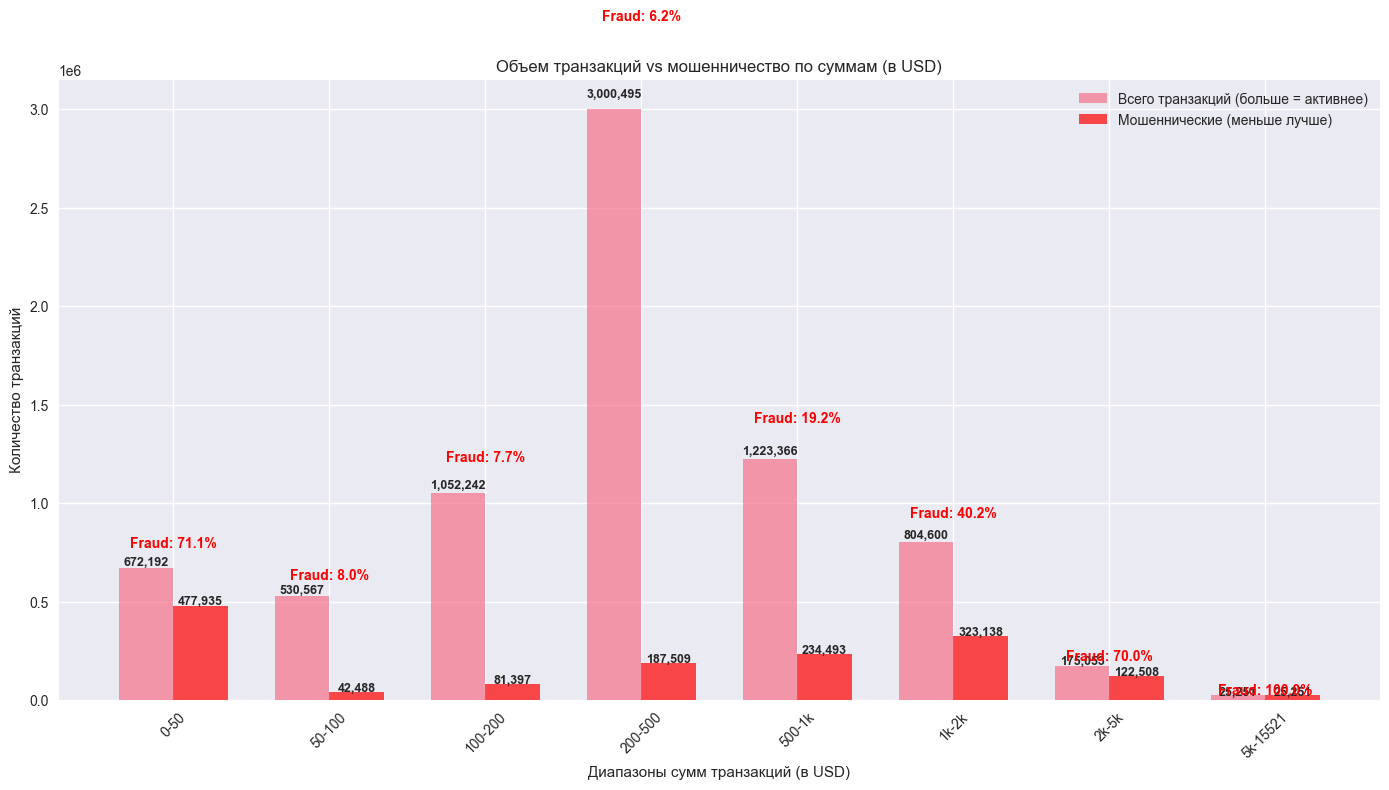


ТАБЛИЦА FRAUD RATE ПО ДИАПАЗОНАМ СУММ:
amount_range  total_transactions  fraud_count  fraud_rate
        0-50              672192       477935     71.1010
      50-100              530567        42488      8.0080
     100-200             1052242        81397      7.7356
     200-500             3000495       187509      6.2493
      500-1k             1223366       234493     19.1679
       1k-2k              804600       323138     40.1613
       2k-5k              175053       122508     69.9834
    5k-15521               25251        25251    100.0000
=== АНАЛИЗ МОШЕННИЧЕСТВА ПО VENDOR_CATEGORY ===


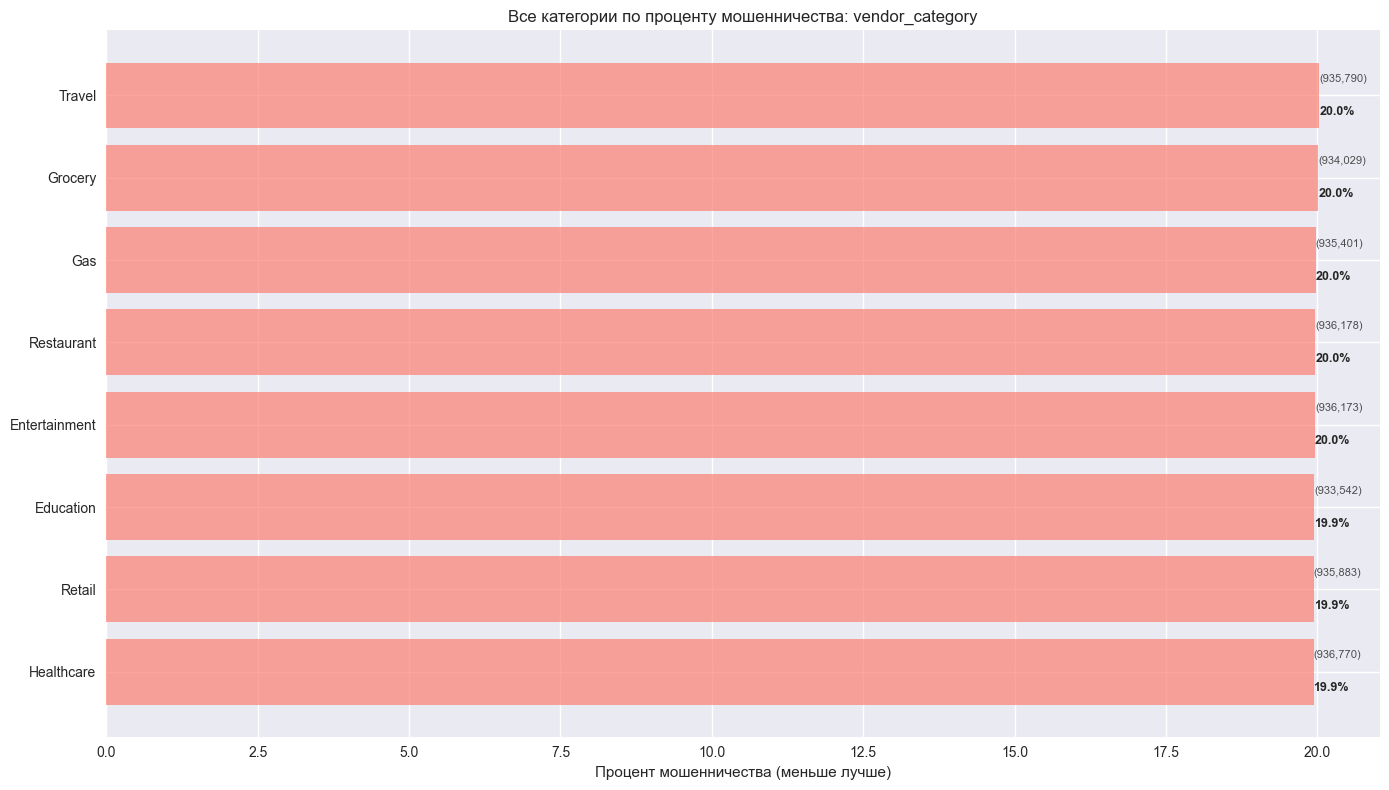


ВСЕ КАТЕГОРИИ ПО FRAUD RATE:
vendor_category  total_transactions  fraud_count  fraud_rate
         Travel              935790       187477     20.0341
        Grocery              934029       186987     20.0194
            Gas              935401       186829     19.9731
     Restaurant              936178       186951     19.9696
  Entertainment              936173       186890     19.9632
      Education              933542       186203     19.9459
         Retail              935883       186613     19.9398
     Healthcare              936770       186769     19.9376

СТАТИСТИКА:
Средний fraud rate: 19.973%
Медианный fraud rate: 19.966%
Максимальный fraud rate: 20.034%
=== АНАЛИЗ МОШЕННИЧЕСТВА ПО COUNTRY ===


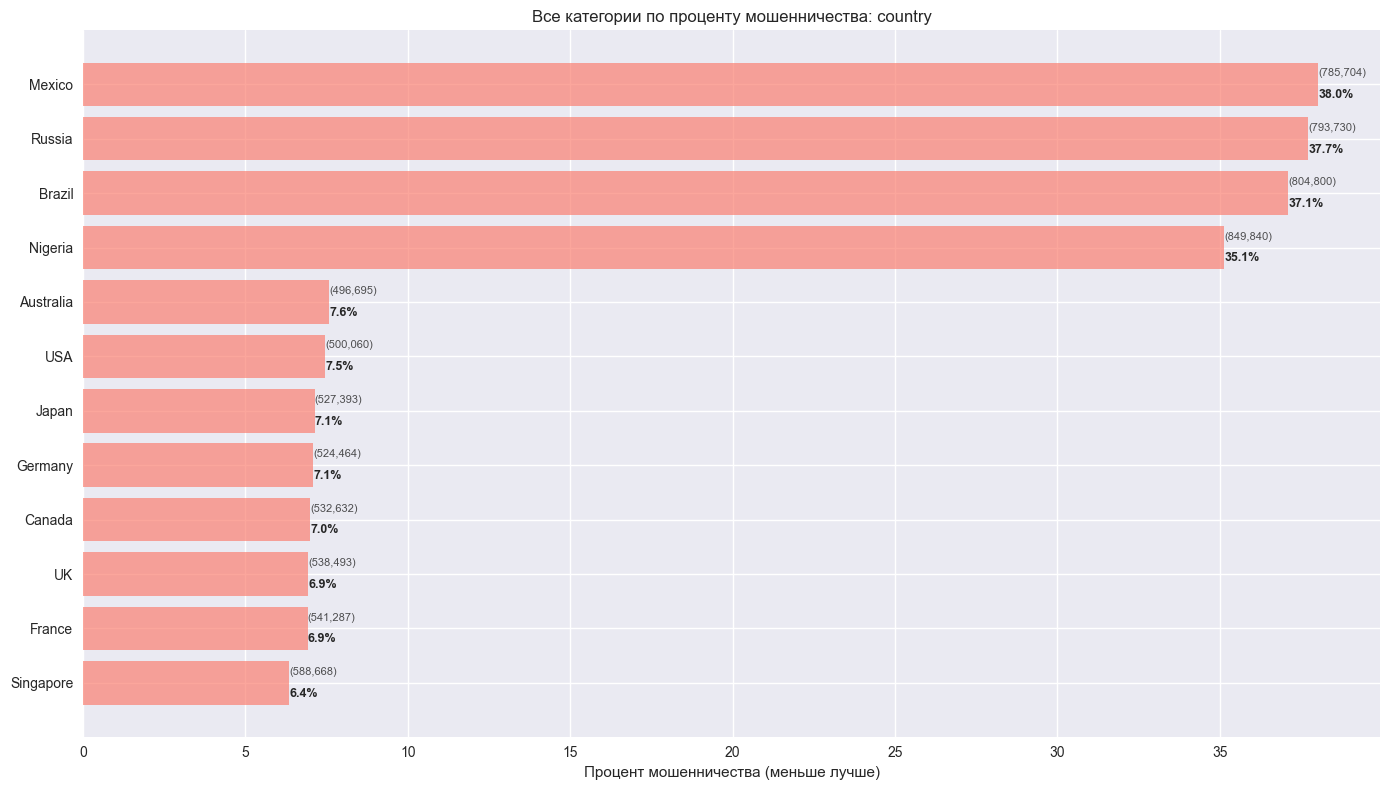


ВСЕ КАТЕГОРИИ ПО FRAUD RATE:
  country  total_transactions  fraud_count  fraud_rate
   Mexico              785704       298841     38.0348
   Russia              793730       299425     37.7238
   Brazil              804800       298629     37.1060
  Nigeria              849840       298600     35.1360
Australia              496695        37652      7.5805
      USA              500060        37312      7.4615
    Japan              527393        37592      7.1279
  Germany              524464        37205      7.0939
   Canada              532632        37278      6.9988
       UK              538493        37345      6.9351
   France              541287        37426      6.9143
Singapore              588668        37414      6.3557

СТАТИСТИКА:
Средний fraud rate: 17.039%
Медианный fraud rate: 7.295%
Максимальный fraud rate: 38.035%
=== АНАЛИЗ МОШЕННИЧЕСТВА ПО CHANNEL ===


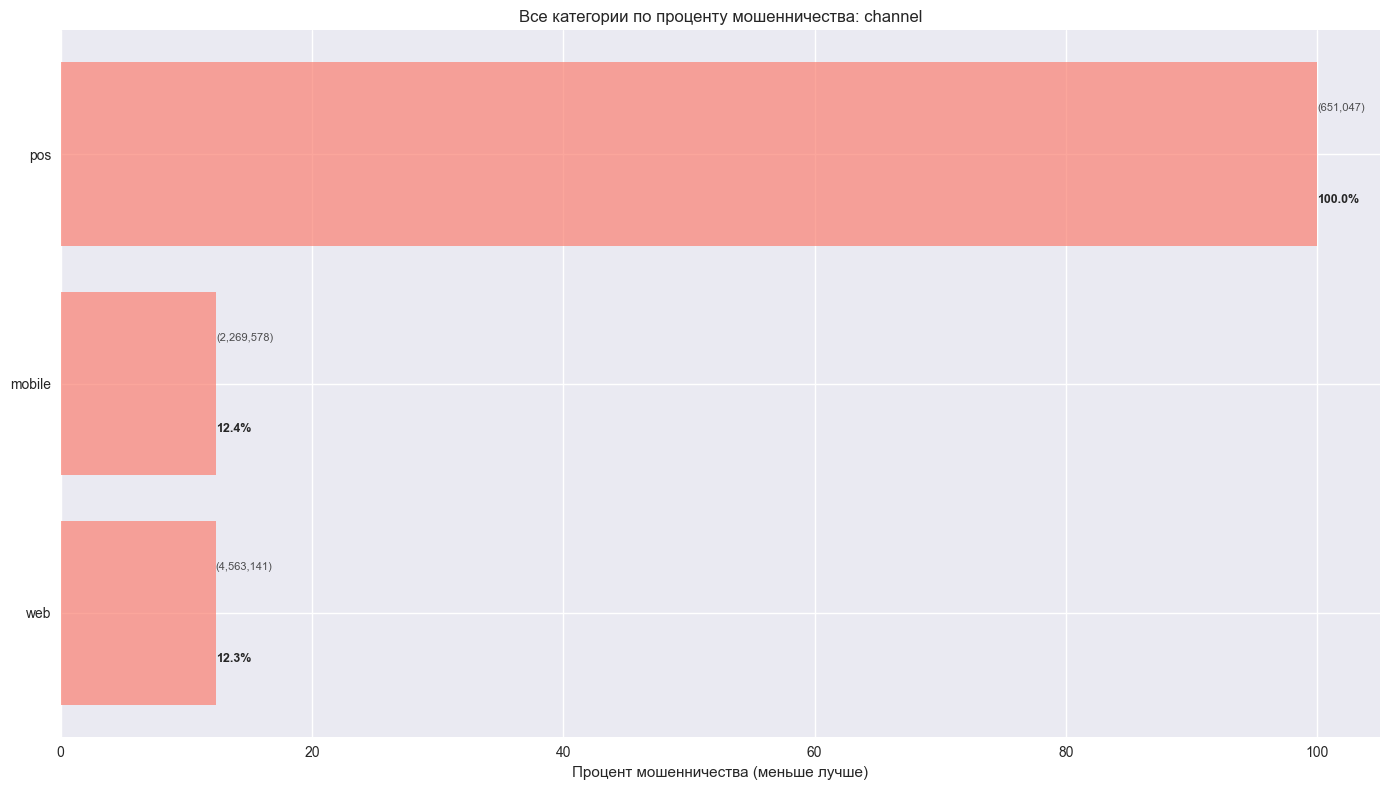


ВСЕ КАТЕГОРИИ ПО FRAUD RATE:
channel  total_transactions  fraud_count  fraud_rate
    pos              651047       651047    100.0000
 mobile             2269578       281150     12.3878
    web             4563141       562522     12.3275

СТАТИСТИКА:
Средний fraud rate: 41.572%
Медианный fraud rate: 12.388%
Максимальный fraud rate: 100.000%
=== АНАЛИЗ МОШЕННИЧЕСТВА ПО DEVICE ===


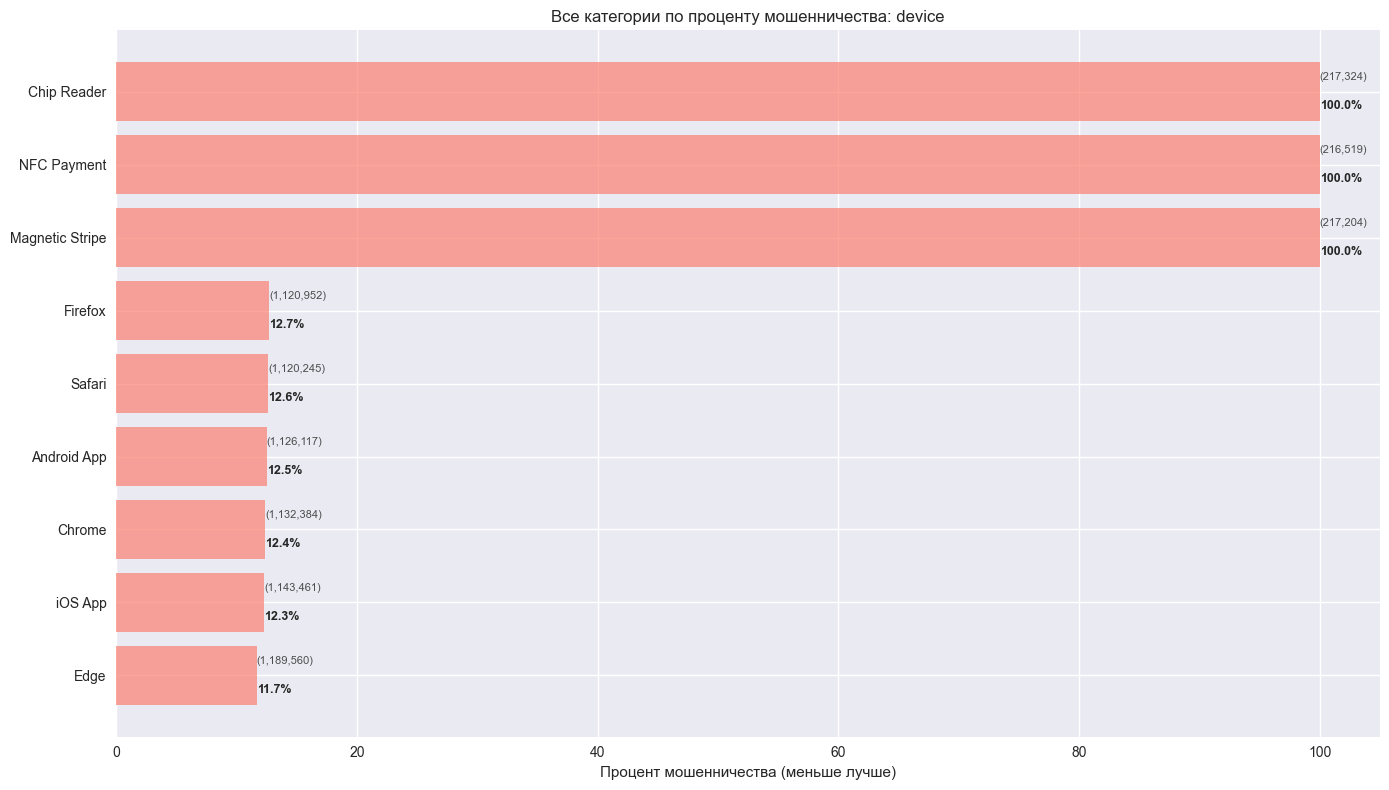


ВСЕ КАТЕГОРИИ ПО FRAUD RATE:
         device  total_transactions  fraud_count  fraud_rate
    Chip Reader              217324       217324    100.0000
    NFC Payment              216519       216519    100.0000
Magnetic Stripe              217204       217204    100.0000
        Firefox             1120952       142171     12.6831
         Safari             1120245       141379     12.6204
    Android App             1126117       140844     12.5070
         Chrome             1132384       140087     12.3710
        iOS App             1143461       140306     12.2703
           Edge             1189560       138885     11.6753

СТАТИСТИКА:
Средний fraud rate: 41.570%
Медианный fraud rate: 12.620%
Максимальный fraud rate: 100.000%
Анализ паттернов мошенничества завершен!


In [8]:
# Анализ паттернов мошенничества
def analyze_fraud_by_amount(df):
    """Анализ fraud rate по диапазонам сумм"""
    
    # Определяем правильное название столбца (приоритет USD после конвертации)
    amount_col = 'amount_usd' if 'amount_usd' in df.columns else 'amount'
    
    if amount_col not in df.columns or 'is_fraud' not in df.columns:
        print(f"Необходимые столбцы не найдены. Нужны: {amount_col}, is_fraud")
        print(f"Доступные столбцы: {list(df.columns)}")
        return
    
    print(f"=== АНАЛИЗ МОШЕННИЧЕСТВА ПО СУММАМ ТРАНЗАКЦИЙ ({amount_col}) ===")
    
    # Создание диапазонов сумм на основе квантилей для более равномерного распределения
    max_amount = df[amount_col].max()
    amount_bins = [0, 50, 100, 200, 500, 1000, 2000, 5000, max_amount]
    amount_labels = ['0-50', '50-100', '100-200', '200-500', '500-1k', '1k-2k', '2k-5k', f'5k-{int(max_amount)}']
    
    df_analysis = df.copy()
    df_analysis['amount_range'] = pd.cut(df_analysis[amount_col], 
                                        bins=amount_bins, 
                                        labels=amount_labels, 
                                        include_lowest=True)
    
    # Группировка и расчет fraud rate
    fraud_by_amount = df_analysis.groupby('amount_range').agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).reset_index()
    
    fraud_by_amount.columns = ['amount_range', 'total_transactions', 'fraud_count', 'fraud_rate']
    fraud_by_amount['fraud_rate'] = fraud_by_amount['fraud_rate'] * 100
    
    # Создание графика (оставляем только один график)
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    # График: Количество транзакций и мошенничества
    x = range(len(fraud_by_amount))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], fraud_by_amount['total_transactions'], 
           width, label='Всего транзакций (больше = активнее)', alpha=0.7)
    ax.bar([i + width/2 for i in x], fraud_by_amount['fraud_count'], 
           width, label='Мошеннические (меньше лучше)', alpha=0.7, color='red')
    
    ax.set_title('Объем транзакций vs мошенничество по суммам (в USD)')
    ax.set_xlabel('Диапазоны сумм транзакций (в USD)')
    ax.set_ylabel('Количество транзакций')
    ax.set_xticks(x)
    ax.set_xticklabels(fraud_by_amount['amount_range'], rotation=45)
    ax.legend()
    
    # Добавляем подписи значений над обоими столбцами
    for i, (total, fraud, rate) in enumerate(zip(fraud_by_amount['total_transactions'], 
                                                 fraud_by_amount['fraud_count'], 
                                                 fraud_by_amount['fraud_rate'])):
        # Подпись над столбцом "Всего транзакций"
        ax.text(i - width/2, total + total * 0.02, f'{total:,}', 
                ha='center', fontsize=9, weight='bold')
        
        # Подпись над столбцом "Мошеннические"
        ax.text(i + width/2, fraud + fraud * 0.02, f'{fraud:,}', 
                ha='center', fontsize=9, weight='bold')
        
        # Fraud rate в центре над обоими столбцами
        max_height = max(total, fraud)
        ax.text(i, max_height + max_height * 0.15, f'Fraud: {rate:.1f}%', 
                ha='center', fontsize=10, weight='bold', color='red')
        

    
    plt.tight_layout()
    plt.show()
    
    # Таблица с результатами
    print("\nТАБЛИЦА FRAUD RATE ПО ДИАПАЗОНАМ СУММ:")
    print(fraud_by_amount.to_string(index=False))
    
    return fraud_by_amount

def analyze_fraud_by_category(df, category_column, top_n=None):
    """Анализ fraud rate по категориям"""
    
    if category_column not in df.columns or 'is_fraud' not in df.columns:
        print(f"Столбец '{category_column}' или 'is_fraud' не найден")
        return
    
    print(f"=== АНАЛИЗ МОШЕННИЧЕСТВА ПО {category_column.upper()} ===")
    
    # Группировка и расчет fraud rate
    fraud_by_category = df.groupby(category_column).agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).reset_index()
    
    fraud_by_category.columns = [category_column, 'total_transactions', 'fraud_count', 'fraud_rate']
    fraud_by_category['fraud_rate'] = fraud_by_category['fraud_rate'] * 100
    
    # Фильтрация только категорий с достаточным количеством транзакций
    min_transactions = 100  # Минимум для статистической значимости
    fraud_by_category = fraud_by_category[fraud_by_category['total_transactions'] >= min_transactions]
    
    # Показываем все категории, отсортированные по fraud rate
    if top_n is None:
        top_n = len(fraud_by_category)  # Показать все
    
    top_fraud_categories = fraud_by_category.nlargest(top_n, 'fraud_rate')
    
    # График
    plt.figure(figsize=(14, max(8, len(top_fraud_categories) * 0.5)))
    plt.barh(range(len(top_fraud_categories)), top_fraud_categories['fraud_rate'], 
             color='salmon', alpha=0.7)
    plt.yticks(range(len(top_fraud_categories)), top_fraud_categories[category_column])
    plt.xlabel('Процент мошенничества (меньше лучше)')
    
    if len(top_fraud_categories) == len(fraud_by_category):
        plt.title(f'Все категории по проценту мошенничества: {category_column}')
    else:
        plt.title(f'Топ-{top_n} категорий по проценту мошенничества: {category_column}')
    
    plt.gca().invert_yaxis()
    
    # Добавление значений с табуляцией (как в категориальных переменных)
    for i, (fraud_rate, transactions) in enumerate(zip(top_fraud_categories['fraud_rate'], 
                                                       top_fraud_categories['total_transactions'])):
        # Процент сверху, абсолютное значение снизу (табуляция)
        plt.text(fraud_rate, i + 0.2, f'{fraud_rate:.1f}%', 
                va='center', fontsize=9, weight='bold', ha='left')
        plt.text(fraud_rate, i - 0.2, f'({transactions:,})', 
                va='center', fontsize=8, alpha=0.8, ha='left')
    
    plt.tight_layout()
    plt.show()
    
    # Таблица с результатами
    if len(top_fraud_categories) == len(fraud_by_category):
        print(f"\nВСЕ КАТЕГОРИИ ПО FRAUD RATE:")
    else:
        print(f"\nТОП-{top_n} КАТЕГОРИЙ ПО FRAUD RATE:")
    print(top_fraud_categories.to_string(index=False))
    
    print(f"\nСТАТИСТИКА:")
    print(f"Средний fraud rate: {fraud_by_category['fraud_rate'].mean():.3f}%")
    print(f"Медианный fraud rate: {fraud_by_category['fraud_rate'].median():.3f}%")
    print(f"Максимальный fraud rate: {fraud_by_category['fraud_rate'].max():.3f}%")
    
    return fraud_by_category

# Запуск анализа паттернов мошенничества
print("Запускаем анализ паттернов мошенничества...")

# Анализ fraud rate по суммам транзакций
fraud_by_amount = analyze_fraud_by_amount(df_with_features)

# Анализ fraud rate по категориям поставщиков
if 'vendor_category' in df_with_features.columns:
    fraud_by_vendor = analyze_fraud_by_category(df_with_features, 'vendor_category')

# Анализ fraud rate по странам
if 'country' in df_with_features.columns:
    fraud_by_country = analyze_fraud_by_category(df_with_features, 'country')

# Анализ fraud rate по каналам транзакций
if 'channel' in df_with_features.columns:
    fraud_by_channel = analyze_fraud_by_category(df_with_features, 'channel')

# Анализ fraud rate по типам устройств
if 'device' in df_with_features.columns:
    fraud_by_device = analyze_fraud_by_category(df_with_features, 'device')

print("Анализ паттернов мошенничества завершен!")


=== АНАЛИЗ ПАТТЕРНОВ НАГРУЗКИ СЕРВЕРОВ ===


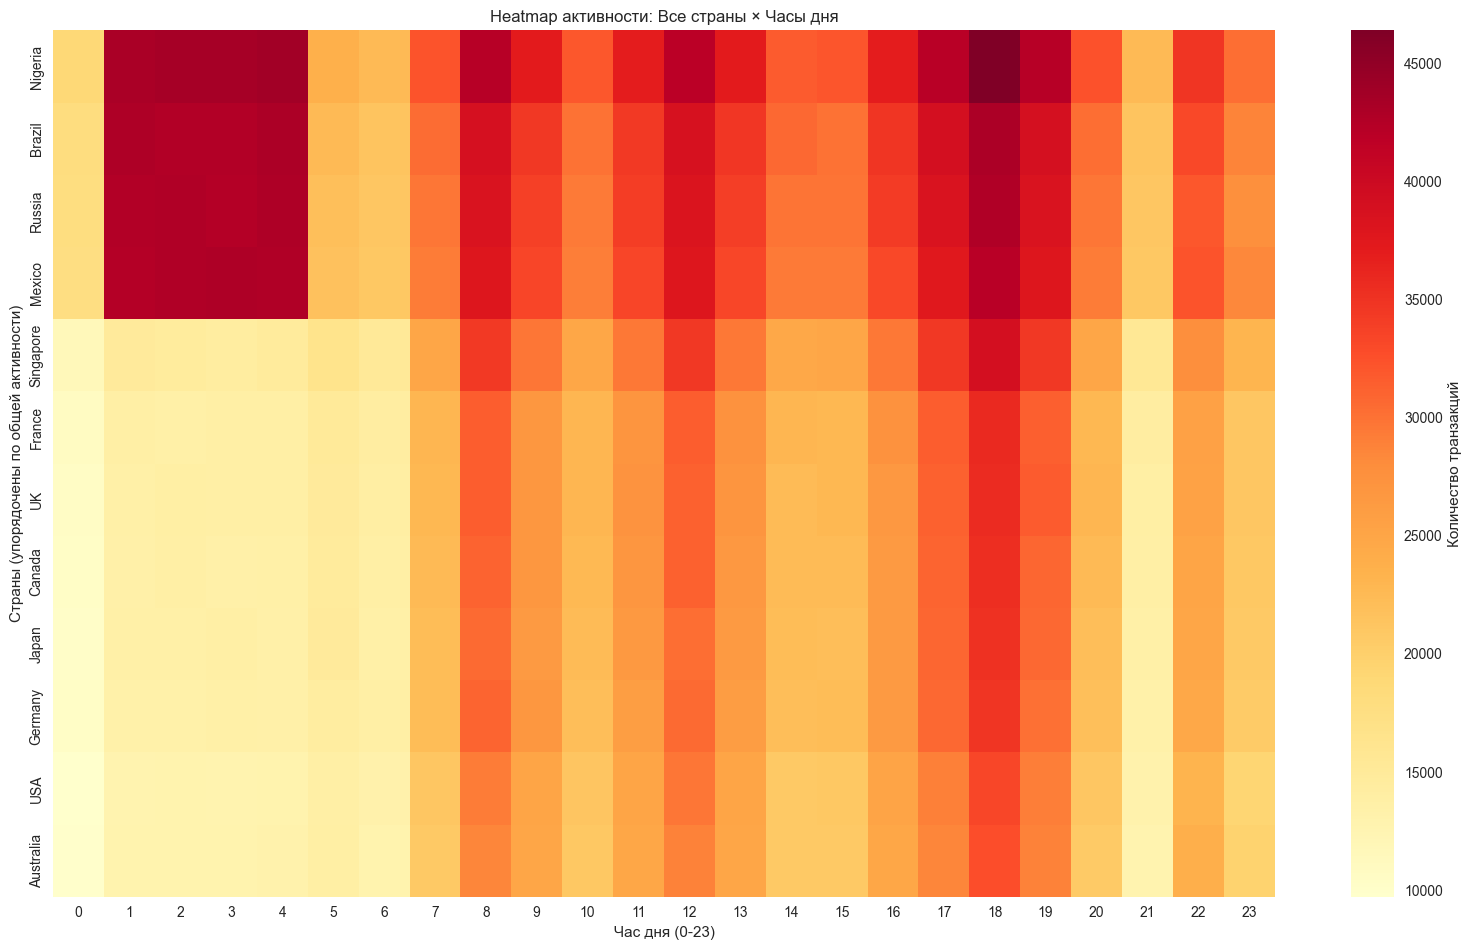


=== ДОПОЛНИТЕЛЬНЫЕ HEATMAP-Ы ПО КАТЕГОРИЯМ ===


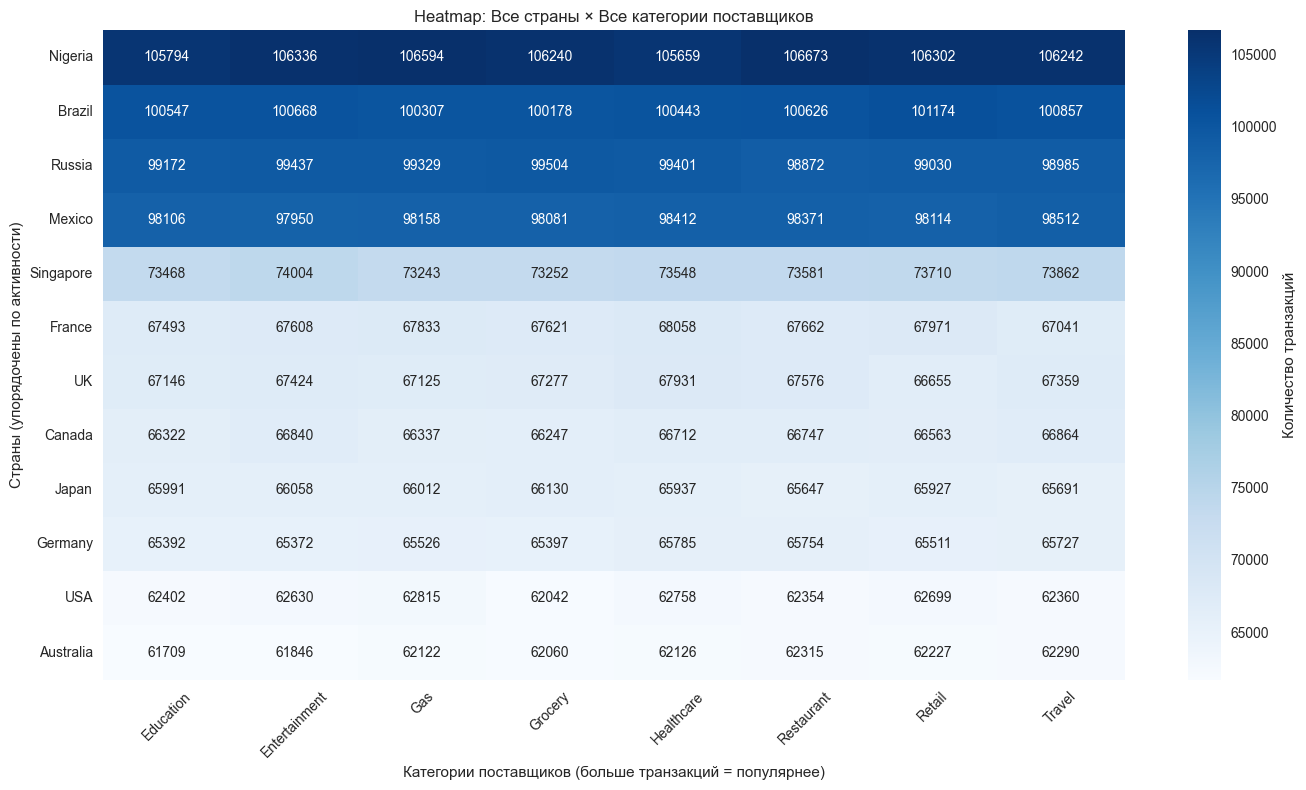

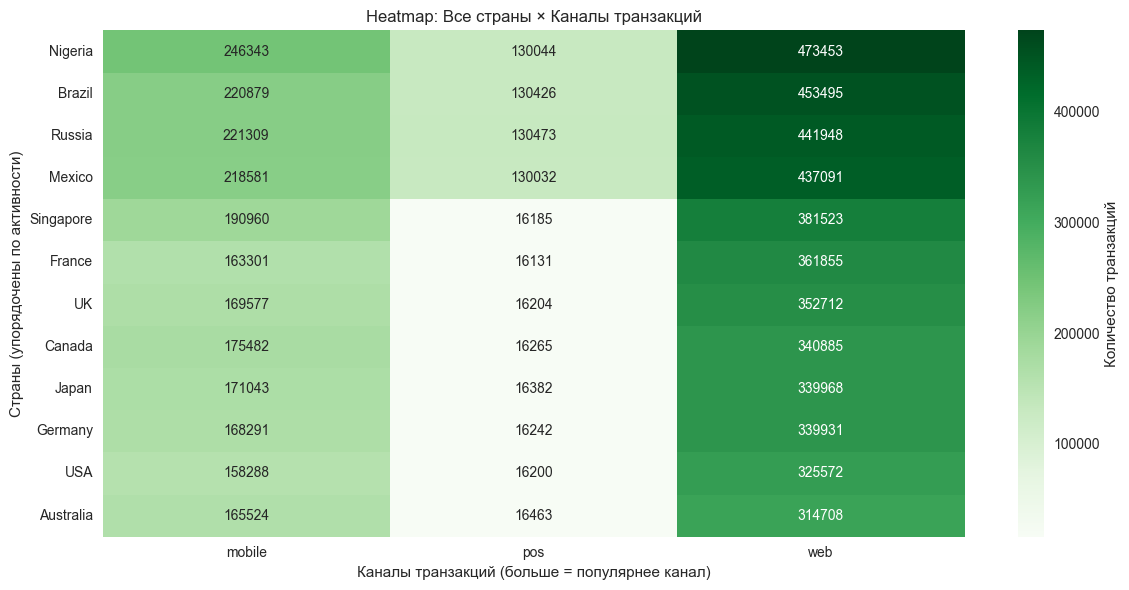

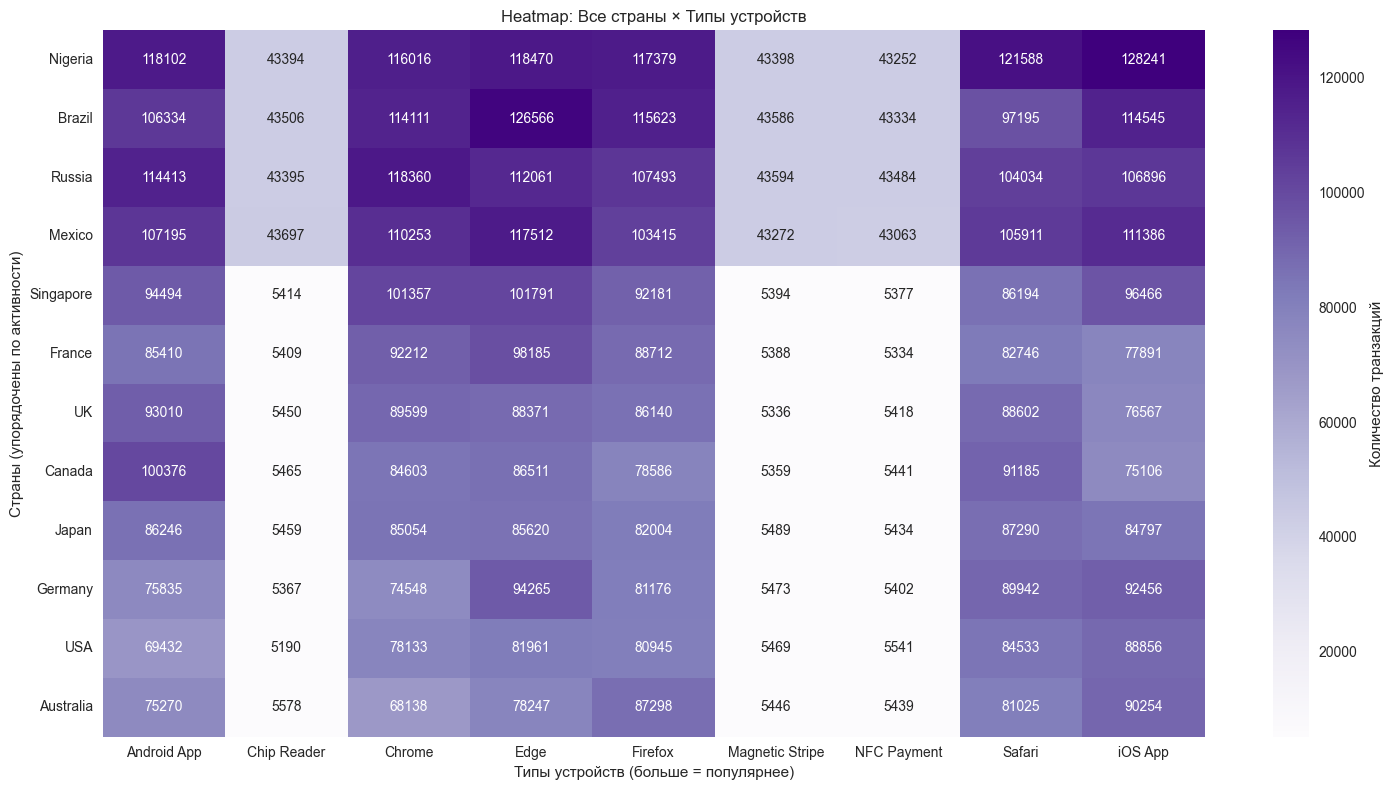

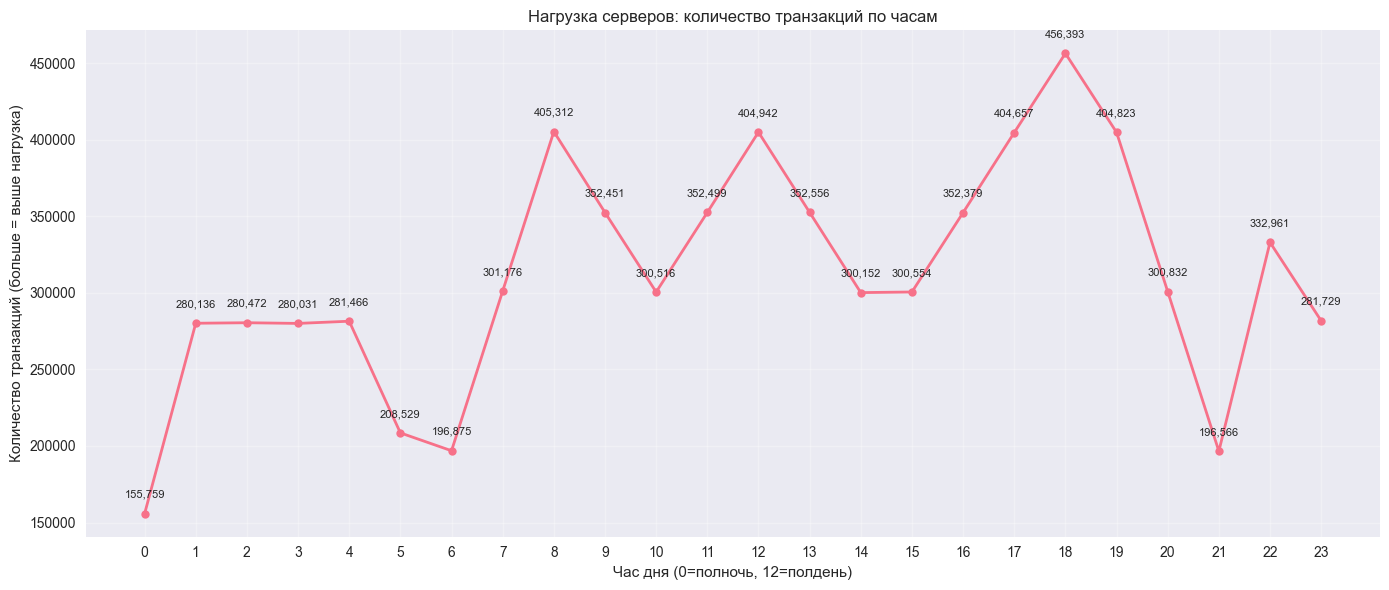

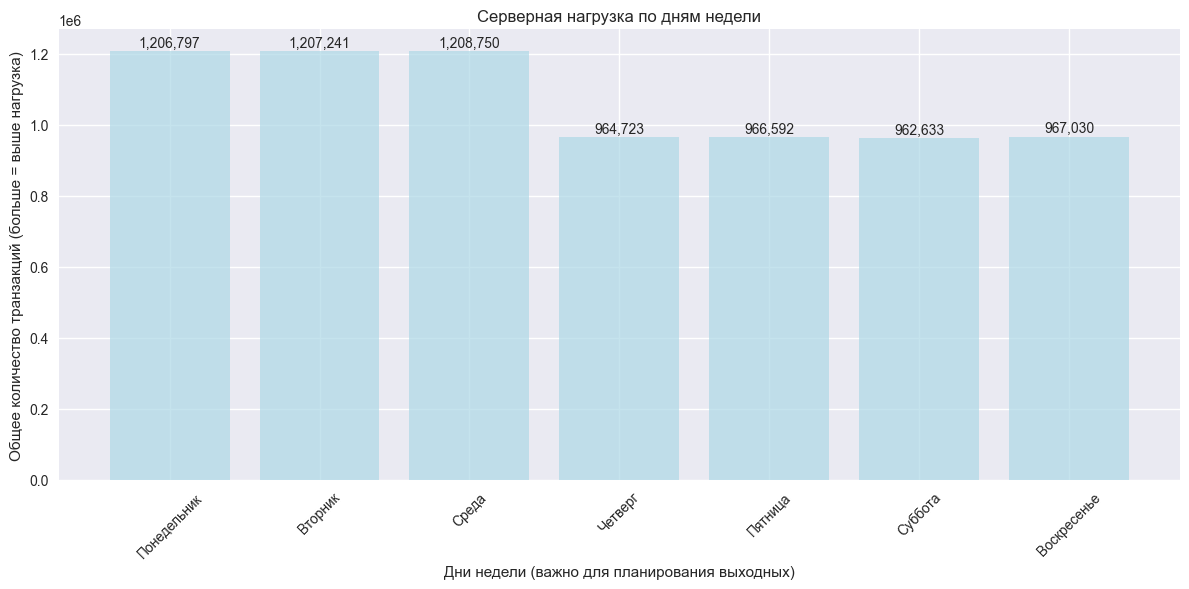


=== ТАБЛИЦА ДЛЯ ПЛАНИРОВАНИЯ СЕРВЕРНЫХ МОЩНОСТЕЙ ===
РЕКОМЕНДАЦИИ ПО ЧАСАМ:
 hour  total_load load_category         scaling_recommendation
    0      155759        Низкая           Минимальные мощности
    1      280136        Низкая           Минимальные мощности
    2      280472        Низкая           Минимальные мощности
    3      280031        Низкая           Минимальные мощности
    4      281466        Низкая           Минимальные мощности
    5      208529        Низкая           Минимальные мощности
    6      196875        Низкая           Минимальные мощности
    7      301176       Средняя           Стандартные мощности
    8      405312   Критическая Максимальные мощности + резерв
    9      352451       Средняя           Стандартные мощности
   10      300516        Низкая           Минимальные мощности
   11      352499       Средняя           Стандартные мощности
   12      404942       Высокая           Увеличенные мощности
   13      352556       Средняя          

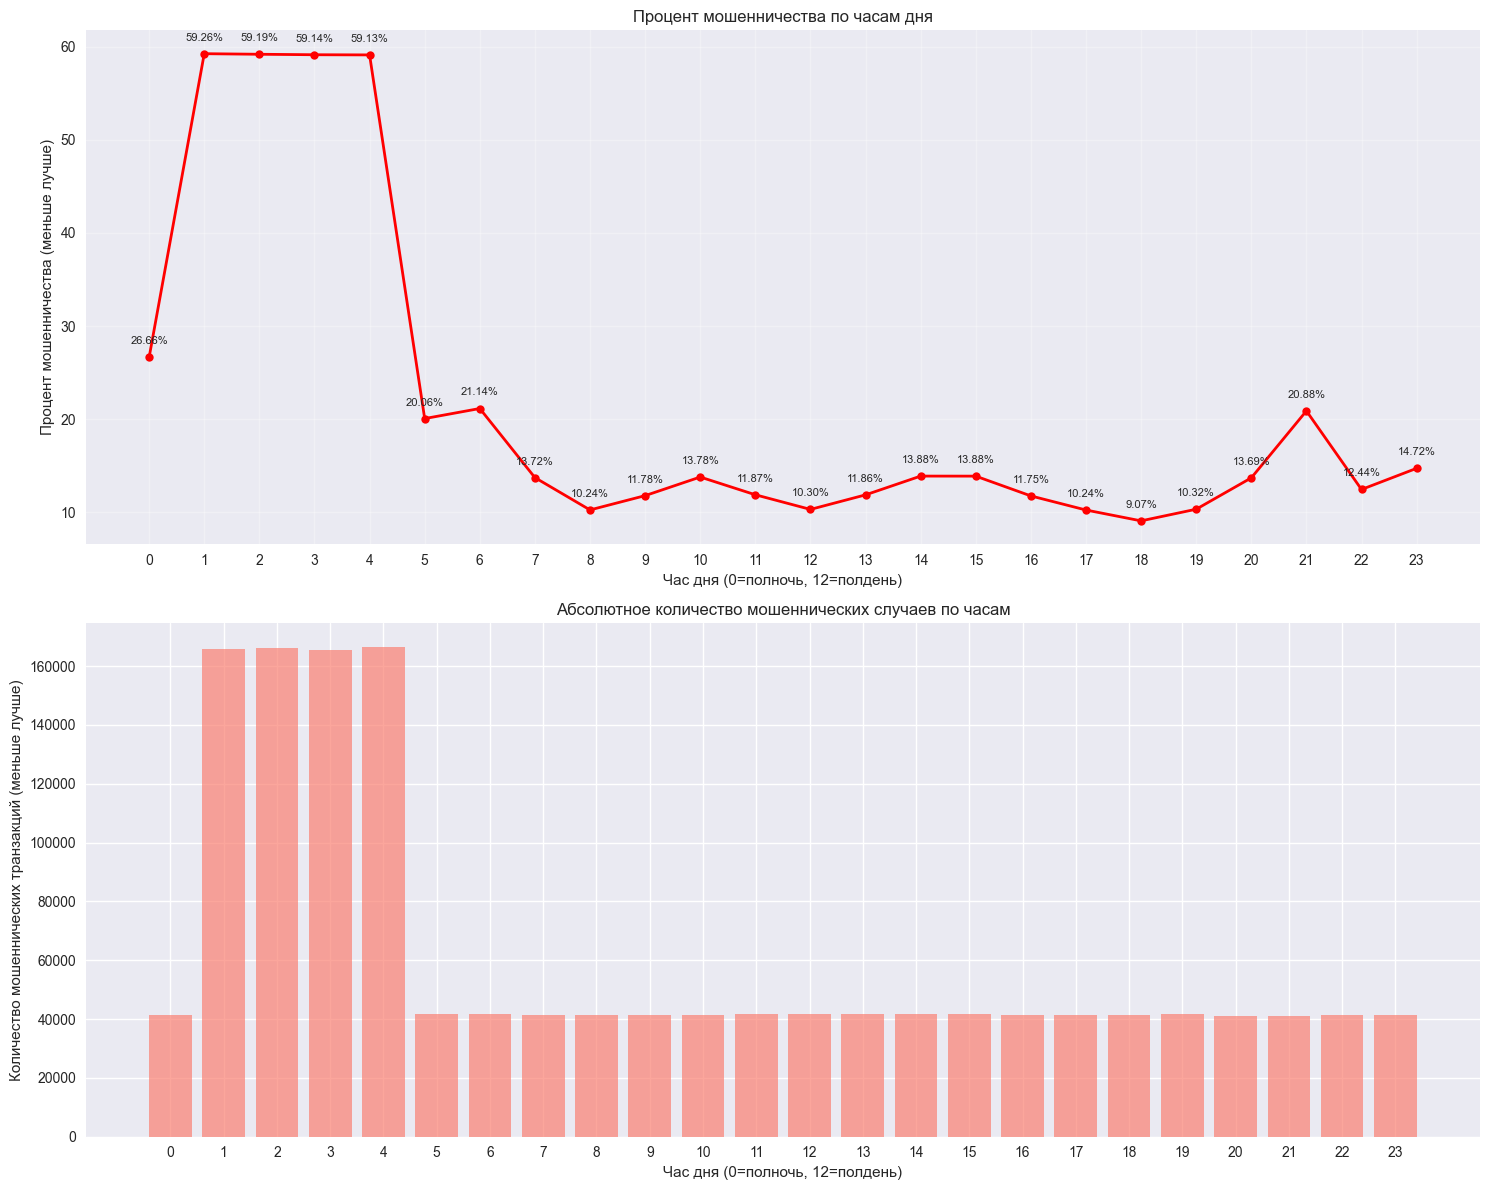


=== ОБЩАЯ СТАТИСТИКА ДАННЫХ ===
Мошеннические транзакции: 1,494,719
Легальные транзакции: 5,989,047
Общий процент мошенничества: 19.97%
Общее количество транзакций: 7,483,766
FRAUD RATE ПО ЧАСАМ:
 hour  total_transactions  fraud_count  fraud_rate
    0              155759        41519     26.6559
    1              280136       165999     59.2566
    2              280472       166025     59.1949
    3              280031       165621     59.1438
    4              281466       166418     59.1254
    5              208529        41829     20.0591
    6              196875        41622     21.1413
    7              301176        41318     13.7189
    8              405312        41523     10.2447
    9              352451        41522     11.7809
   10              300516        41410     13.7796
   11              352499        41857     11.8744
   12              404942        41716     10.3017
   13              352556        41829     11.8645
   14              300152        41665

In [9]:
# Временной и географический анализ
def analyze_server_load_patterns(df):
    """Анализ паттернов нагрузки для оптимизации серверов"""
    
    df_analysis = df.copy()
    
    # Проверяем и создаем столбец hour если его нет
    if 'hour' not in df_analysis.columns and 'timestamp' in df_analysis.columns:
        print("Создаем столбец 'hour' из timestamp...")
        df_analysis['timestamp'] = pd.to_datetime(df_analysis['timestamp'])
        df_analysis['hour'] = df_analysis['timestamp'].dt.hour
    
    required_columns = ['timestamp', 'country', 'hour']
    missing_columns = [col for col in required_columns if col not in df_analysis.columns]
    
    if missing_columns:
        print(f"Отсутствуют столбцы: {missing_columns}")
        print(f"Доступные столбцы: {list(df_analysis.columns)}")
        return
    
    print("=== АНАЛИЗ ПАТТЕРНОВ НАГРУЗКИ СЕРВЕРОВ ===")
    
    # Используем подготовленные данные
    df_load = df_analysis
    
    # Анализ по часам и странам
    hourly_country_load = df_load.groupby(['hour', 'country']).size().reset_index(name='transaction_count')
    
    # Все страны, отсортированные по общему объему транзакций
    all_countries = df_load['country'].value_counts().index.tolist()
    
    # Используем все страны для анализа
    hourly_country_all = hourly_country_load
    
    # Создание pivot table для heatmap
    heatmap_data = hourly_country_all.pivot(index='country', columns='hour', values='transaction_count')
    heatmap_data = heatmap_data.fillna(0)
    
    # Сортируем страны по общей активности
    country_totals = heatmap_data.sum(axis=1).sort_values(ascending=False)
    heatmap_data = heatmap_data.loc[country_totals.index]
    
    # График 1: Heatmap нагрузки по часам и странам
    plt.figure(figsize=(16, max(8, len(all_countries) * 0.8)))
    sns.heatmap(heatmap_data, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Количество транзакций'})
    plt.title('Heatmap активности: Все страны × Часы дня')
    plt.xlabel('Час дня (0-23)')
    plt.ylabel('Страны (упорядочены по общей активности)')
    plt.tight_layout()
    plt.show()
    
    # Дополнительные heatmap-ы по категориям
    print("\n=== ДОПОЛНИТЕЛЬНЫЕ HEATMAP-Ы ПО КАТЕГОРИЯМ ===")
    
    # Heatmap по vendor_category для всех стран
    if 'vendor_category' in df_load.columns:
        vendor_country_data = df_load.groupby(['country', 'vendor_category']).size().reset_index(name='transaction_count')
        vendor_pivot = vendor_country_data.pivot(index='country', columns='vendor_category', values='transaction_count')
        vendor_pivot = vendor_pivot.fillna(0)
        
        # Сортируем страны по общей активности
        vendor_country_totals = vendor_pivot.sum(axis=1).sort_values(ascending=False)
        vendor_pivot = vendor_pivot.loc[vendor_country_totals.index]
        
        plt.figure(figsize=(14, max(8, len(all_countries) * 0.6)))
        sns.heatmap(vendor_pivot, annot=True, fmt='.0f', cmap='Blues', 
                   cbar_kws={'label': 'Количество транзакций'})
        plt.title('Heatmap: Все страны × Все категории поставщиков')
        plt.xlabel('Категории поставщиков (больше транзакций = популярнее)')
        plt.ylabel('Страны (упорядочены по активности)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Heatmap по channel для всех стран
    if 'channel' in df_load.columns:
        channel_country_data = df_load.groupby(['country', 'channel']).size().reset_index(name='transaction_count')
        channel_pivot = channel_country_data.pivot(index='country', columns='channel', values='transaction_count')
        channel_pivot = channel_pivot.fillna(0)
        
        # Сортируем страны по общей активности
        channel_country_totals = channel_pivot.sum(axis=1).sort_values(ascending=False)
        channel_pivot = channel_pivot.loc[channel_country_totals.index]
        
        plt.figure(figsize=(12, max(6, len(all_countries) * 0.5)))
        sns.heatmap(channel_pivot, annot=True, fmt='.0f', cmap='Greens',
                   cbar_kws={'label': 'Количество транзакций'})
        plt.title('Heatmap: Все страны × Каналы транзакций')
        plt.xlabel('Каналы транзакций (больше = популярнее канал)')
        plt.ylabel('Страны (упорядочены по активности)')
        plt.tight_layout()
        plt.show()
    
    # Heatmap по device для всех стран
    if 'device' in df_load.columns:
        device_country_data = df_load.groupby(['country', 'device']).size().reset_index(name='transaction_count')
        device_pivot = device_country_data.pivot(index='country', columns='device', values='transaction_count')
        device_pivot = device_pivot.fillna(0)
        
        # Сортируем страны по общей активности
        device_country_totals = device_pivot.sum(axis=1).sort_values(ascending=False)
        device_pivot = device_pivot.loc[device_country_totals.index]
        
        plt.figure(figsize=(15, max(8, len(all_countries) * 0.6)))
        sns.heatmap(device_pivot, annot=True, fmt='.0f', cmap='Purples',
                   cbar_kws={'label': 'Количество транзакций'})
        plt.title('Heatmap: Все страны × Типы устройств')
        plt.xlabel('Типы устройств (больше = популярнее)')
        plt.ylabel('Страны (упорядочены по активности)')
        plt.tight_layout()
        plt.show()
    
    # График 2: Общая нагрузка по часам
    hourly_load = df_load.groupby('hour').size()
    
    plt.figure(figsize=(14, 6))
    plt.plot(hourly_load.index, hourly_load.values, marker='o', linewidth=2, markersize=6)
    plt.title('Нагрузка серверов: количество транзакций по часам')
    plt.xlabel('Час дня (0=полночь, 12=полдень)')
    plt.ylabel('Количество транзакций (больше = выше нагрузка)')
    plt.grid(True, alpha=0.3)
    plt.xticks(range(0, 24))
    
    # Добавление подписей значений во всех точках
    for hour, count in hourly_load.items():
        plt.text(hour, count + max(hourly_load) * 0.02, f'{count:,}', 
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # График 3: Нагрузка по дням недели
    if 'day_of_week' in df_load.columns:
        weekly_load = df_load.groupby('day_of_week').size()
        day_names = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
        
        plt.figure(figsize=(12, 6))
        plt.bar(range(7), weekly_load.values, color='lightblue', alpha=0.7)
        plt.title('Серверная нагрузка по дням недели')
        plt.xlabel('Дни недели (важно для планирования выходных)')
        plt.ylabel('Общее количество транзакций (больше = выше нагрузка)')
        plt.xticks(range(7), day_names, rotation=45)
        
        # Добавление значений на столбцы
        for i, v in enumerate(weekly_load.values):
            plt.text(i, v + max(weekly_load) * 0.01, f'{v:,}', ha='center')
        
        plt.tight_layout()
        plt.show()
    
    # Создание таблицы для планирования серверных мощностей
    server_planning_table = create_server_planning_table(df_load, all_countries)
    
    return {
        'hourly_load': hourly_load,
        'heatmap_data': heatmap_data,
        'server_planning': server_planning_table
    }

def create_server_planning_table(df, top_countries):
    """Создание таблицы для планирования серверных мощностей"""
    
    print("\n=== ТАБЛИЦА ДЛЯ ПЛАНИРОВАНИЯ СЕРВЕРНЫХ МОЩНОСТЕЙ ===")
    
    # Общая статистика по часам
    hourly_stats = df.groupby('hour').size().reset_index(name='total_transactions').set_index('hour')
    
    # Статистика по странам и часам
    country_hour_stats = df[df['country'].isin(top_countries)].groupby(['country', 'hour']).size().reset_index(name='transactions')
    
    # Пиковые часы для каждой страны
    country_peaks = country_hour_stats.loc[country_hour_stats.groupby('country')['transactions'].idxmax()]
    
    # Создание сводной таблицы
    planning_table = pd.DataFrame()
    planning_table['hour'] = range(24)
    
    # Безопасное заполнение данных
    load_values = []
    for hour in range(24):
        if hour in hourly_stats.index:
            load_values.append(hourly_stats.loc[hour, 'total_transactions'])
        else:
            load_values.append(0)
    planning_table['total_load'] = load_values
    
    # Определение уровня нагрузки
    def categorize_load(load, percentiles):
        if load >= percentiles[0.95]:
            return 'Критическая'
        elif load >= percentiles[0.80]:
            return 'Высокая'
        elif load >= percentiles[0.50]:
            return 'Средняя'
        else:
            return 'Низкая'
    
    load_percentiles = planning_table['total_load'].quantile([0.5, 0.8, 0.95])
    planning_table['load_category'] = planning_table['total_load'].apply(
        lambda x: categorize_load(x, load_percentiles)
    )
    
    # Рекомендации по масштабированию
    def get_scaling_recommendation(category):
        recommendations = {
            'Критическая': 'Максимальные мощности + резерв',
            'Высокая': 'Увеличенные мощности',
            'Средняя': 'Стандартные мощности',
            'Низкая': 'Минимальные мощности'
        }
        return recommendations.get(category, 'Стандартные мощности')
    
    planning_table['scaling_recommendation'] = planning_table['load_category'].apply(get_scaling_recommendation)
    
    print("РЕКОМЕНДАЦИИ ПО ЧАСАМ:")
    print(planning_table.to_string(index=False))
    
    # Топ-5 пиковых часов
    peak_hours = planning_table.nlargest(5, 'total_load')[['hour', 'total_load', 'load_category']]
    print(f"\nТОП-5 ПИКОВЫХ ЧАСОВ:")
    print(peak_hours.to_string(index=False))
    
    # Рекомендации по странам
    print(f"\nПИКОВЫЕ ЧАСЫ ПО ТОП-СТРАНАМ:")
    for _, row in country_peaks.iterrows():
        print(f"  {row['country']}: час {row['hour']} ({row['transactions']:,} транзакций)")
    
    return planning_table

def analyze_fraud_time_patterns(df):
    """Анализ временных паттернов мошенничества"""
    
    df_analysis = df.copy()
    
    # Создаем столбец hour если его нет
    if 'hour' not in df_analysis.columns and 'timestamp' in df_analysis.columns:
        print("Создаем столбец 'hour' из timestamp...")
        df_analysis['timestamp'] = pd.to_datetime(df_analysis['timestamp'])
        df_analysis['hour'] = df_analysis['timestamp'].dt.hour
    
    required_columns = ['hour', 'is_fraud']
    missing_columns = [col for col in required_columns if col not in df_analysis.columns]
    
    if missing_columns:
        print(f"Отсутствуют столбцы: {missing_columns}")
        print(f"Доступные столбцы: {list(df_analysis.columns)}")
        return
    
    print("\n=== ВРЕМЕННЫЕ ПАТТЕРНЫ МОШЕННИЧЕСТВА ===")
    
    # Fraud rate по часам
    hourly_fraud = df_analysis.groupby('hour').agg({
        'is_fraud': ['count', 'sum', 'mean']
    }).reset_index()
    hourly_fraud.columns = ['hour', 'total_transactions', 'fraud_count', 'fraud_rate']
    hourly_fraud['fraud_rate'] = hourly_fraud['fraud_rate'] * 100
    
    # График fraud rate по часам
    fig, axes = plt.subplots(2, 1, figsize=(15, 12))
    
    # График 1: Fraud rate по часам
    axes[0].plot(hourly_fraud['hour'], hourly_fraud['fraud_rate'], 
                marker='o', linewidth=2, markersize=6, color='red')
    axes[0].set_title('Процент мошенничества по часам дня')
    axes[0].set_xlabel('Час дня (0=полночь, 12=полдень)')
    axes[0].set_ylabel('Процент мошенничества (меньше лучше)')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(range(0, 24))
    
    # Добавление подписей значений во всех точках
    for _, row in hourly_fraud.iterrows():
        axes[0].text(row['hour'], row['fraud_rate'] + max(hourly_fraud['fraud_rate']) * 0.02, 
                    f'{row["fraud_rate"]:.2f}%', ha='center', va='bottom', fontsize=8)
    
    # График 2: Количество мошеннических транзакций по часам
    axes[1].bar(hourly_fraud['hour'], hourly_fraud['fraud_count'], 
               color='salmon', alpha=0.7)
    axes[1].set_title('Абсолютное количество мошеннических случаев по часам')
    axes[1].set_xlabel('Час дня (0=полночь, 12=полдень)')
    axes[1].set_ylabel('Количество мошеннических транзакций (меньше лучше)')
    axes[1].set_xticks(range(0, 24))
    
    plt.tight_layout()
    plt.show()
    
    # Fraud rate по дням недели (если есть данные)
    if 'day_of_week' in df_analysis.columns:
        daily_fraud = df_analysis.groupby('day_of_week').agg({
            'is_fraud': ['count', 'sum', 'mean']
        }).reset_index()
    elif 'timestamp' in df_analysis.columns:
        # Создаем day_of_week из timestamp
        df_analysis['day_of_week'] = df_analysis['timestamp'].dt.dayofweek
        daily_fraud = df_analysis.groupby('day_of_week').agg({
            'is_fraud': ['count', 'sum', 'mean']
        }).reset_index()
        daily_fraud.columns = ['day_of_week', 'total_transactions', 'fraud_count', 'fraud_rate']
        daily_fraud['fraud_rate'] = daily_fraud['fraud_rate'] * 100
        
        day_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
        
        plt.figure(figsize=(12, 6))
        plt.bar(range(7), daily_fraud['fraud_rate'], color='orange', alpha=0.7)
        plt.title('Процент мошенничества по дням недели')
        plt.xlabel('Дни недели (Пн-рабочий, Сб-Вс-выходные)')
        plt.ylabel('Процент мошенничества (меньше лучше)')
        plt.xticks(range(7), day_names)
        
        # Добавление значений
        for i, v in enumerate(daily_fraud['fraud_rate']):
            plt.text(i, v + 0.05, f'{v:.2f}%', ha='center')
        
            plt.tight_layout()
    plt.show()
    
    # Дополнительная статистика по данным
    fraud_count = df_analysis['is_fraud'].sum()
    legit_count = len(df_analysis) - fraud_count
    print(f"\n=== ОБЩАЯ СТАТИСТИКА ДАННЫХ ===")
    print(f"Мошеннические транзакции: {fraud_count:,}")
    print(f"Легальные транзакции: {legit_count:,}")
    print(f"Общий процент мошенничества: {fraud_count/len(df_analysis)*100:.2f}%")
    print(f"Общее количество транзакций: {len(df_analysis):,}")
    
    # Таблица с результатами
    print("FRAUD RATE ПО ЧАСАМ:")
    print(hourly_fraud.to_string(index=False))
    
    # Выводы
    peak_fraud_hour = hourly_fraud.loc[hourly_fraud['fraud_rate'].idxmax()]
    low_fraud_hour = hourly_fraud.loc[hourly_fraud['fraud_rate'].idxmin()]
    
    print(f"\nВЫВОДЫ:")
    print(f"Час с максимальным fraud rate: {peak_fraud_hour['hour']} ({peak_fraud_hour['fraud_rate']:.3f}%)")
    print(f"Час с минимальным fraud rate: {low_fraud_hour['hour']} ({low_fraud_hour['fraud_rate']:.3f}%)")
    print(f"Разница между максимумом и минимумом: {peak_fraud_hour['fraud_rate'] - low_fraud_hour['fraud_rate']:.3f}%")
    
    return hourly_fraud

server_analysis = analyze_server_load_patterns(df_with_features)
fraud_time_analysis = analyze_fraud_time_patterns(df_with_features)

print("Функции временного и географического анализа готовы")



--- АНАЛИЗ ПО ТИПУ КАРТЫ ---


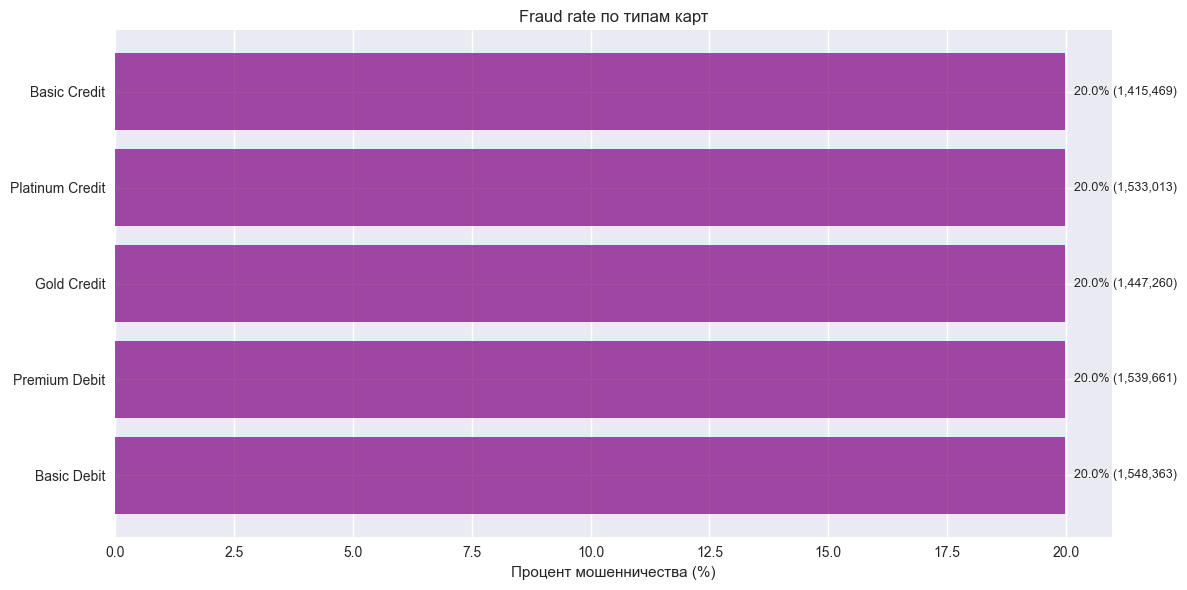

FRAUD RATE ПО ТИПАМ КАРТ:
      card_type  total_transactions  fraud_count  fraud_rate
   Basic Credit             1415469       282728     19.9742
Platinum Credit             1533013       306190     19.9731
    Gold Credit             1447260       289060     19.9729
  Premium Debit             1539661       307502     19.9721
    Basic Debit             1548363       309239     19.9720

Анализ распределния по типу Карт завершен


In [10]:
def analyze_demographic_patterns(df):
    # Анализ по типу карты
    if 'card_type' in df.columns and 'is_fraud' in df.columns:
        print("\n--- АНАЛИЗ ПО ТИПУ КАРТЫ ---")
        
        card_fraud = df.groupby('card_type').agg({
            'is_fraud': ['count', 'sum', 'mean']
        }).reset_index()
        card_fraud.columns = ['card_type', 'total_transactions', 'fraud_count', 'fraud_rate']
        card_fraud['fraud_rate'] = card_fraud['fraud_rate'] * 100
        card_fraud = card_fraud.sort_values('fraud_rate', ascending=False)
        
        # График
        plt.figure(figsize=(12, 6))
        plt.barh(range(len(card_fraud)), card_fraud['fraud_rate'], 
                color='purple', alpha=0.7)
        plt.yticks(range(len(card_fraud)), card_fraud['card_type'])
        plt.xlabel('Процент мошенничества (%)')
        plt.title('Fraud rate по типам карт')
        plt.gca().invert_yaxis()
        
        # Добавляем значения
        for i, (rate, transactions) in enumerate(zip(card_fraud['fraud_rate'], 
                                                   card_fraud['total_transactions'])):
            plt.text(rate + 0.2, i, f'{rate:.1f}% ({transactions:,})', 
                    va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        print("FRAUD RATE ПО ТИПАМ КАРТ:")
        print(card_fraud.to_string(index=False))
    
    return {
        'card_analysis': card_fraud if 'card_type' in df.columns else None
    }

demographic_analysis = analyze_demographic_patterns(df_with_features)
print("\nАнализ распределния по типу Карт завершен")